In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import pandas as pd
import numpy as np
from sklearn import preprocessing

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Define Path to Dataset

In [4]:
DATA_PATH = 'Data/wine.csv'

# Define Functions

In [94]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, 1:]
    df_wine = df.iloc[:,0].values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # stadardize values
    standardizer = preprocessing.StandardScaler()
    x_train = standardizer.fit_transform(x)
    x_train = torch.from_numpy(x_train).to(device)
    return x_train, standardizer, df_wine

# Build DataLoader

In [95]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        self.x, self.standardizer, self.wine = load_data(DATA_PATH)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [96]:
data_set=DataBuilder(DATA_PATH)
trainloader=DataLoader(dataset=data_set,batch_size=1024)

In [97]:
type(trainloader.dataset.x)

torch.Tensor

In [98]:
data_set.x

tensor([[ 1.5186, -0.5622,  0.2321,  ...,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280,  ...,  0.4061,  1.1134,  0.9652],
        [ 0.1969,  0.0212,  1.1093,  ...,  0.3183,  0.7886,  1.3951],
        ...,
        [ 0.3328,  1.7447, -0.3894,  ..., -1.6121, -1.4854,  0.2806],
        [ 0.2092,  0.2277,  0.0127,  ..., -1.5683, -1.4007,  0.2965],
        [ 1.3951,  1.5832,  1.3652,  ..., -1.5244, -1.4289, -0.5952]])

# Build Model and train it

In [99]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,H2)
        self.linear3=nn.Linear(H2,H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
#        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
#         self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
#         self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H)
        self.linear5=nn.Linear(H,H)
        self.linear6=nn.Linear(H,D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.linear1(x))
        lin2 = self.relu(self.linear2(lin1))
        lin3 = self.relu(self.linear3(lin2))

        fc1 = F.relu(self.fc1(lin3))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc3(z))
        fc4 = self.relu(self.fc4(fc3))#.view(128, -1)

        lin4 = self.relu(self.linear4(fc4))
        lin5 = self.relu(self.linear5(lin4))
        return self.linear6(lin5)


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        # self.decode(z) ist später recon_batch, mu ist mu und logvar ist logvar
        return self.decode(z), mu, logvar

In [100]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [101]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [102]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
#model.apply(weights_init_uniform_rule)
#sae.fc4.register_forward_hook(get_activation('fc4'))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [103]:
loss_mse = customLoss()

# Train

In [104]:
epochs = 10000
log_interval = 50
val_losses = []
train_losses = []

In [105]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                       100. * batch_idx / len(trainloader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(trainloader.dataset)))
    train_losses.append(train_loss / len(trainloader.dataset))

In [106]:
def test(epoch):
    model.eval()
    test_loss = 0
    # no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
    with torch.no_grad():
        for i, data in enumerate(valloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
            
                
    test_loss /= len(valloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [107]:
for epoch in range(1, epochs + 1):
    train(epoch)
#    test(epoch)

Train Epoch: 1 [0/178 (0%)]	Loss: 13.381590
====> Epoch: 1 Average loss: 13.3816
Train Epoch: 2 [0/178 (0%)]	Loss: 13.348895
====> Epoch: 2 Average loss: 13.3489
Train Epoch: 3 [0/178 (0%)]	Loss: 13.343742
====> Epoch: 3 Average loss: 13.3437
Train Epoch: 4 [0/178 (0%)]	Loss: 13.323950
====> Epoch: 4 Average loss: 13.3239
Train Epoch: 5 [0/178 (0%)]	Loss: 13.303326
====> Epoch: 5 Average loss: 13.3033
Train Epoch: 6 [0/178 (0%)]	Loss: 13.278323
====> Epoch: 6 Average loss: 13.2783
Train Epoch: 7 [0/178 (0%)]	Loss: 13.279638
====> Epoch: 7 Average loss: 13.2796
Train Epoch: 8 [0/178 (0%)]	Loss: 13.243783
====> Epoch: 8 Average loss: 13.2438
Train Epoch: 9 [0/178 (0%)]	Loss: 13.262717
====> Epoch: 9 Average loss: 13.2627
Train Epoch: 10 [0/178 (0%)]	Loss: 13.250911
====> Epoch: 10 Average loss: 13.2509
Train Epoch: 11 [0/178 (0%)]	Loss: 13.220987
====> Epoch: 11 Average loss: 13.2210
Train Epoch: 12 [0/178 (0%)]	Loss: 13.220983
====> Epoch: 12 Average loss: 13.2210
Train Epoch: 13 [0/178

====> Epoch: 99 Average loss: 13.0382
Train Epoch: 100 [0/178 (0%)]	Loss: 13.029143
====> Epoch: 100 Average loss: 13.0291
Train Epoch: 101 [0/178 (0%)]	Loss: 13.034266
====> Epoch: 101 Average loss: 13.0343
Train Epoch: 102 [0/178 (0%)]	Loss: 13.016606
====> Epoch: 102 Average loss: 13.0166
Train Epoch: 103 [0/178 (0%)]	Loss: 13.021796
====> Epoch: 103 Average loss: 13.0218
Train Epoch: 104 [0/178 (0%)]	Loss: 13.020127
====> Epoch: 104 Average loss: 13.0201
Train Epoch: 105 [0/178 (0%)]	Loss: 13.033033
====> Epoch: 105 Average loss: 13.0330
Train Epoch: 106 [0/178 (0%)]	Loss: 13.038622
====> Epoch: 106 Average loss: 13.0386
Train Epoch: 107 [0/178 (0%)]	Loss: 13.031424
====> Epoch: 107 Average loss: 13.0314
Train Epoch: 108 [0/178 (0%)]	Loss: 13.024558
====> Epoch: 108 Average loss: 13.0246
Train Epoch: 109 [0/178 (0%)]	Loss: 13.019109
====> Epoch: 109 Average loss: 13.0191
Train Epoch: 110 [0/178 (0%)]	Loss: 13.015803
====> Epoch: 110 Average loss: 13.0158
Train Epoch: 111 [0/178 (0%

====> Epoch: 195 Average loss: 13.0103
Train Epoch: 196 [0/178 (0%)]	Loss: 12.998616
====> Epoch: 196 Average loss: 12.9986
Train Epoch: 197 [0/178 (0%)]	Loss: 13.006810
====> Epoch: 197 Average loss: 13.0068
Train Epoch: 198 [0/178 (0%)]	Loss: 13.021225
====> Epoch: 198 Average loss: 13.0212
Train Epoch: 199 [0/178 (0%)]	Loss: 13.009722
====> Epoch: 199 Average loss: 13.0097
Train Epoch: 200 [0/178 (0%)]	Loss: 12.981489
====> Epoch: 200 Average loss: 12.9815
Train Epoch: 201 [0/178 (0%)]	Loss: 12.991186
====> Epoch: 201 Average loss: 12.9912
Train Epoch: 202 [0/178 (0%)]	Loss: 12.999446
====> Epoch: 202 Average loss: 12.9994
Train Epoch: 203 [0/178 (0%)]	Loss: 12.996461
====> Epoch: 203 Average loss: 12.9965
Train Epoch: 204 [0/178 (0%)]	Loss: 12.988658
====> Epoch: 204 Average loss: 12.9887
Train Epoch: 205 [0/178 (0%)]	Loss: 13.004876
====> Epoch: 205 Average loss: 13.0049
Train Epoch: 206 [0/178 (0%)]	Loss: 13.005489
====> Epoch: 206 Average loss: 13.0055
Train Epoch: 207 [0/178 (0

====> Epoch: 291 Average loss: 11.2436
Train Epoch: 292 [0/178 (0%)]	Loss: 10.647795
====> Epoch: 292 Average loss: 10.6478
Train Epoch: 293 [0/178 (0%)]	Loss: 10.584061
====> Epoch: 293 Average loss: 10.5841
Train Epoch: 294 [0/178 (0%)]	Loss: 11.000911
====> Epoch: 294 Average loss: 11.0009
Train Epoch: 295 [0/178 (0%)]	Loss: 10.859436
====> Epoch: 295 Average loss: 10.8594
Train Epoch: 296 [0/178 (0%)]	Loss: 11.061696
====> Epoch: 296 Average loss: 11.0617
Train Epoch: 297 [0/178 (0%)]	Loss: 10.665992
====> Epoch: 297 Average loss: 10.6660
Train Epoch: 298 [0/178 (0%)]	Loss: 11.013025
====> Epoch: 298 Average loss: 11.0130
Train Epoch: 299 [0/178 (0%)]	Loss: 10.493164
====> Epoch: 299 Average loss: 10.4932
Train Epoch: 300 [0/178 (0%)]	Loss: 11.077308
====> Epoch: 300 Average loss: 11.0773
Train Epoch: 301 [0/178 (0%)]	Loss: 10.612353
====> Epoch: 301 Average loss: 10.6124
Train Epoch: 302 [0/178 (0%)]	Loss: 10.700270
====> Epoch: 302 Average loss: 10.7003
Train Epoch: 303 [0/178 (0

Train Epoch: 388 [0/178 (0%)]	Loss: 9.993369
====> Epoch: 388 Average loss: 9.9934
Train Epoch: 389 [0/178 (0%)]	Loss: 9.989517
====> Epoch: 389 Average loss: 9.9895
Train Epoch: 390 [0/178 (0%)]	Loss: 10.078659
====> Epoch: 390 Average loss: 10.0787
Train Epoch: 391 [0/178 (0%)]	Loss: 10.610848
====> Epoch: 391 Average loss: 10.6108
Train Epoch: 392 [0/178 (0%)]	Loss: 10.008477
====> Epoch: 392 Average loss: 10.0085
Train Epoch: 393 [0/178 (0%)]	Loss: 10.051367
====> Epoch: 393 Average loss: 10.0514
Train Epoch: 394 [0/178 (0%)]	Loss: 10.098105
====> Epoch: 394 Average loss: 10.0981
Train Epoch: 395 [0/178 (0%)]	Loss: 10.309077
====> Epoch: 395 Average loss: 10.3091
Train Epoch: 396 [0/178 (0%)]	Loss: 10.179587
====> Epoch: 396 Average loss: 10.1796
Train Epoch: 397 [0/178 (0%)]	Loss: 10.247761
====> Epoch: 397 Average loss: 10.2478
Train Epoch: 398 [0/178 (0%)]	Loss: 10.603151
====> Epoch: 398 Average loss: 10.6032
Train Epoch: 399 [0/178 (0%)]	Loss: 10.224738
====> Epoch: 399 Averag

====> Epoch: 485 Average loss: 9.7432
Train Epoch: 486 [0/178 (0%)]	Loss: 9.477931
====> Epoch: 486 Average loss: 9.4779
Train Epoch: 487 [0/178 (0%)]	Loss: 9.905786
====> Epoch: 487 Average loss: 9.9058
Train Epoch: 488 [0/178 (0%)]	Loss: 9.998921
====> Epoch: 488 Average loss: 9.9989
Train Epoch: 489 [0/178 (0%)]	Loss: 9.588380
====> Epoch: 489 Average loss: 9.5884
Train Epoch: 490 [0/178 (0%)]	Loss: 9.907053
====> Epoch: 490 Average loss: 9.9071
Train Epoch: 491 [0/178 (0%)]	Loss: 9.635582
====> Epoch: 491 Average loss: 9.6356
Train Epoch: 492 [0/178 (0%)]	Loss: 9.547297
====> Epoch: 492 Average loss: 9.5473
Train Epoch: 493 [0/178 (0%)]	Loss: 9.776268
====> Epoch: 493 Average loss: 9.7763
Train Epoch: 494 [0/178 (0%)]	Loss: 9.759696
====> Epoch: 494 Average loss: 9.7597
Train Epoch: 495 [0/178 (0%)]	Loss: 9.722931
====> Epoch: 495 Average loss: 9.7229
Train Epoch: 496 [0/178 (0%)]	Loss: 9.419210
====> Epoch: 496 Average loss: 9.4192
Train Epoch: 497 [0/178 (0%)]	Loss: 9.467902
====

Train Epoch: 584 [0/178 (0%)]	Loss: 9.444970
====> Epoch: 584 Average loss: 9.4450
Train Epoch: 585 [0/178 (0%)]	Loss: 9.214102
====> Epoch: 585 Average loss: 9.2141
Train Epoch: 586 [0/178 (0%)]	Loss: 9.440880
====> Epoch: 586 Average loss: 9.4409
Train Epoch: 587 [0/178 (0%)]	Loss: 9.308558
====> Epoch: 587 Average loss: 9.3086
Train Epoch: 588 [0/178 (0%)]	Loss: 9.415130
====> Epoch: 588 Average loss: 9.4151
Train Epoch: 589 [0/178 (0%)]	Loss: 9.488356
====> Epoch: 589 Average loss: 9.4884
Train Epoch: 590 [0/178 (0%)]	Loss: 9.598108
====> Epoch: 590 Average loss: 9.5981
Train Epoch: 591 [0/178 (0%)]	Loss: 9.397875
====> Epoch: 591 Average loss: 9.3979
Train Epoch: 592 [0/178 (0%)]	Loss: 9.525417
====> Epoch: 592 Average loss: 9.5254
Train Epoch: 593 [0/178 (0%)]	Loss: 9.170752
====> Epoch: 593 Average loss: 9.1708
Train Epoch: 594 [0/178 (0%)]	Loss: 9.398706
====> Epoch: 594 Average loss: 9.3987
Train Epoch: 595 [0/178 (0%)]	Loss: 9.608371
====> Epoch: 595 Average loss: 9.6084
Trai

====> Epoch: 682 Average loss: 9.2626
Train Epoch: 683 [0/178 (0%)]	Loss: 9.443814
====> Epoch: 683 Average loss: 9.4438
Train Epoch: 684 [0/178 (0%)]	Loss: 9.266595
====> Epoch: 684 Average loss: 9.2666
Train Epoch: 685 [0/178 (0%)]	Loss: 9.271842
====> Epoch: 685 Average loss: 9.2718
Train Epoch: 686 [0/178 (0%)]	Loss: 9.300042
====> Epoch: 686 Average loss: 9.3000
Train Epoch: 687 [0/178 (0%)]	Loss: 9.205287
====> Epoch: 687 Average loss: 9.2053
Train Epoch: 688 [0/178 (0%)]	Loss: 9.286633
====> Epoch: 688 Average loss: 9.2866
Train Epoch: 689 [0/178 (0%)]	Loss: 9.545571
====> Epoch: 689 Average loss: 9.5456
Train Epoch: 690 [0/178 (0%)]	Loss: 9.783423
====> Epoch: 690 Average loss: 9.7834
Train Epoch: 691 [0/178 (0%)]	Loss: 9.699178
====> Epoch: 691 Average loss: 9.6992
Train Epoch: 692 [0/178 (0%)]	Loss: 9.493773
====> Epoch: 692 Average loss: 9.4938
Train Epoch: 693 [0/178 (0%)]	Loss: 9.828139
====> Epoch: 693 Average loss: 9.8281
Train Epoch: 694 [0/178 (0%)]	Loss: 9.113494
====

Train Epoch: 781 [0/178 (0%)]	Loss: 9.509254
====> Epoch: 781 Average loss: 9.5093
Train Epoch: 782 [0/178 (0%)]	Loss: 9.126208
====> Epoch: 782 Average loss: 9.1262
Train Epoch: 783 [0/178 (0%)]	Loss: 9.356083
====> Epoch: 783 Average loss: 9.3561
Train Epoch: 784 [0/178 (0%)]	Loss: 9.165010
====> Epoch: 784 Average loss: 9.1650
Train Epoch: 785 [0/178 (0%)]	Loss: 9.062360
====> Epoch: 785 Average loss: 9.0624
Train Epoch: 786 [0/178 (0%)]	Loss: 9.104398
====> Epoch: 786 Average loss: 9.1044
Train Epoch: 787 [0/178 (0%)]	Loss: 9.038265
====> Epoch: 787 Average loss: 9.0383
Train Epoch: 788 [0/178 (0%)]	Loss: 8.953849
====> Epoch: 788 Average loss: 8.9538
Train Epoch: 789 [0/178 (0%)]	Loss: 9.435676
====> Epoch: 789 Average loss: 9.4357
Train Epoch: 790 [0/178 (0%)]	Loss: 9.104520
====> Epoch: 790 Average loss: 9.1045
Train Epoch: 791 [0/178 (0%)]	Loss: 9.223112
====> Epoch: 791 Average loss: 9.2231
Train Epoch: 792 [0/178 (0%)]	Loss: 9.296425
====> Epoch: 792 Average loss: 9.2964
Trai

====> Epoch: 879 Average loss: 9.1570
Train Epoch: 880 [0/178 (0%)]	Loss: 9.178035
====> Epoch: 880 Average loss: 9.1780
Train Epoch: 881 [0/178 (0%)]	Loss: 9.133349
====> Epoch: 881 Average loss: 9.1333
Train Epoch: 882 [0/178 (0%)]	Loss: 9.289822
====> Epoch: 882 Average loss: 9.2898
Train Epoch: 883 [0/178 (0%)]	Loss: 9.105714
====> Epoch: 883 Average loss: 9.1057
Train Epoch: 884 [0/178 (0%)]	Loss: 9.292463
====> Epoch: 884 Average loss: 9.2925
Train Epoch: 885 [0/178 (0%)]	Loss: 9.132567
====> Epoch: 885 Average loss: 9.1326
Train Epoch: 886 [0/178 (0%)]	Loss: 9.247298
====> Epoch: 886 Average loss: 9.2473
Train Epoch: 887 [0/178 (0%)]	Loss: 9.375277
====> Epoch: 887 Average loss: 9.3753
Train Epoch: 888 [0/178 (0%)]	Loss: 9.116411
====> Epoch: 888 Average loss: 9.1164
Train Epoch: 889 [0/178 (0%)]	Loss: 9.235237
====> Epoch: 889 Average loss: 9.2352
Train Epoch: 890 [0/178 (0%)]	Loss: 9.119015
====> Epoch: 890 Average loss: 9.1190
Train Epoch: 891 [0/178 (0%)]	Loss: 9.161601
====

Train Epoch: 978 [0/178 (0%)]	Loss: 9.134831
====> Epoch: 978 Average loss: 9.1348
Train Epoch: 979 [0/178 (0%)]	Loss: 9.006905
====> Epoch: 979 Average loss: 9.0069
Train Epoch: 980 [0/178 (0%)]	Loss: 9.066332
====> Epoch: 980 Average loss: 9.0663
Train Epoch: 981 [0/178 (0%)]	Loss: 9.193992
====> Epoch: 981 Average loss: 9.1940
Train Epoch: 982 [0/178 (0%)]	Loss: 9.101043
====> Epoch: 982 Average loss: 9.1010
Train Epoch: 983 [0/178 (0%)]	Loss: 9.337543
====> Epoch: 983 Average loss: 9.3375
Train Epoch: 984 [0/178 (0%)]	Loss: 9.072661
====> Epoch: 984 Average loss: 9.0727
Train Epoch: 985 [0/178 (0%)]	Loss: 9.549140
====> Epoch: 985 Average loss: 9.5491
Train Epoch: 986 [0/178 (0%)]	Loss: 8.956075
====> Epoch: 986 Average loss: 8.9561
Train Epoch: 987 [0/178 (0%)]	Loss: 9.039104
====> Epoch: 987 Average loss: 9.0391
Train Epoch: 988 [0/178 (0%)]	Loss: 9.492752
====> Epoch: 988 Average loss: 9.4928
Train Epoch: 989 [0/178 (0%)]	Loss: 9.086766
====> Epoch: 989 Average loss: 9.0868
Trai

====> Epoch: 1074 Average loss: 9.1242
Train Epoch: 1075 [0/178 (0%)]	Loss: 8.979429
====> Epoch: 1075 Average loss: 8.9794
Train Epoch: 1076 [0/178 (0%)]	Loss: 9.148459
====> Epoch: 1076 Average loss: 9.1485
Train Epoch: 1077 [0/178 (0%)]	Loss: 9.161142
====> Epoch: 1077 Average loss: 9.1611
Train Epoch: 1078 [0/178 (0%)]	Loss: 9.090477
====> Epoch: 1078 Average loss: 9.0905
Train Epoch: 1079 [0/178 (0%)]	Loss: 8.797793
====> Epoch: 1079 Average loss: 8.7978
Train Epoch: 1080 [0/178 (0%)]	Loss: 9.016152
====> Epoch: 1080 Average loss: 9.0162
Train Epoch: 1081 [0/178 (0%)]	Loss: 9.094057
====> Epoch: 1081 Average loss: 9.0941
Train Epoch: 1082 [0/178 (0%)]	Loss: 9.169158
====> Epoch: 1082 Average loss: 9.1692
Train Epoch: 1083 [0/178 (0%)]	Loss: 9.025596
====> Epoch: 1083 Average loss: 9.0256
Train Epoch: 1084 [0/178 (0%)]	Loss: 9.017430
====> Epoch: 1084 Average loss: 9.0174
Train Epoch: 1085 [0/178 (0%)]	Loss: 9.173400
====> Epoch: 1085 Average loss: 9.1734
Train Epoch: 1086 [0/178 (

====> Epoch: 1170 Average loss: 8.8370
Train Epoch: 1171 [0/178 (0%)]	Loss: 8.692924
====> Epoch: 1171 Average loss: 8.6929
Train Epoch: 1172 [0/178 (0%)]	Loss: 8.694335
====> Epoch: 1172 Average loss: 8.6943
Train Epoch: 1173 [0/178 (0%)]	Loss: 8.960146
====> Epoch: 1173 Average loss: 8.9601
Train Epoch: 1174 [0/178 (0%)]	Loss: 8.799482
====> Epoch: 1174 Average loss: 8.7995
Train Epoch: 1175 [0/178 (0%)]	Loss: 8.769270
====> Epoch: 1175 Average loss: 8.7693
Train Epoch: 1176 [0/178 (0%)]	Loss: 9.046241
====> Epoch: 1176 Average loss: 9.0462
Train Epoch: 1177 [0/178 (0%)]	Loss: 8.842102
====> Epoch: 1177 Average loss: 8.8421
Train Epoch: 1178 [0/178 (0%)]	Loss: 8.835407
====> Epoch: 1178 Average loss: 8.8354
Train Epoch: 1179 [0/178 (0%)]	Loss: 8.596674
====> Epoch: 1179 Average loss: 8.5967
Train Epoch: 1180 [0/178 (0%)]	Loss: 8.800035
====> Epoch: 1180 Average loss: 8.8000
Train Epoch: 1181 [0/178 (0%)]	Loss: 8.648859
====> Epoch: 1181 Average loss: 8.6489
Train Epoch: 1182 [0/178 (

====> Epoch: 1266 Average loss: 8.7263
Train Epoch: 1267 [0/178 (0%)]	Loss: 8.550296
====> Epoch: 1267 Average loss: 8.5503
Train Epoch: 1268 [0/178 (0%)]	Loss: 8.837701
====> Epoch: 1268 Average loss: 8.8377
Train Epoch: 1269 [0/178 (0%)]	Loss: 8.848778
====> Epoch: 1269 Average loss: 8.8488
Train Epoch: 1270 [0/178 (0%)]	Loss: 8.590774
====> Epoch: 1270 Average loss: 8.5908
Train Epoch: 1271 [0/178 (0%)]	Loss: 8.513319
====> Epoch: 1271 Average loss: 8.5133
Train Epoch: 1272 [0/178 (0%)]	Loss: 8.616194
====> Epoch: 1272 Average loss: 8.6162
Train Epoch: 1273 [0/178 (0%)]	Loss: 8.843404
====> Epoch: 1273 Average loss: 8.8434
Train Epoch: 1274 [0/178 (0%)]	Loss: 8.777521
====> Epoch: 1274 Average loss: 8.7775
Train Epoch: 1275 [0/178 (0%)]	Loss: 8.842334
====> Epoch: 1275 Average loss: 8.8423
Train Epoch: 1276 [0/178 (0%)]	Loss: 9.081354
====> Epoch: 1276 Average loss: 9.0814
Train Epoch: 1277 [0/178 (0%)]	Loss: 8.496636
====> Epoch: 1277 Average loss: 8.4966
Train Epoch: 1278 [0/178 (

====> Epoch: 1362 Average loss: 8.4814
Train Epoch: 1363 [0/178 (0%)]	Loss: 8.679182
====> Epoch: 1363 Average loss: 8.6792
Train Epoch: 1364 [0/178 (0%)]	Loss: 8.431775
====> Epoch: 1364 Average loss: 8.4318
Train Epoch: 1365 [0/178 (0%)]	Loss: 8.588827
====> Epoch: 1365 Average loss: 8.5888
Train Epoch: 1366 [0/178 (0%)]	Loss: 8.471397
====> Epoch: 1366 Average loss: 8.4714
Train Epoch: 1367 [0/178 (0%)]	Loss: 8.319959
====> Epoch: 1367 Average loss: 8.3200
Train Epoch: 1368 [0/178 (0%)]	Loss: 8.512060
====> Epoch: 1368 Average loss: 8.5121
Train Epoch: 1369 [0/178 (0%)]	Loss: 8.446984
====> Epoch: 1369 Average loss: 8.4470
Train Epoch: 1370 [0/178 (0%)]	Loss: 8.446257
====> Epoch: 1370 Average loss: 8.4463
Train Epoch: 1371 [0/178 (0%)]	Loss: 8.571605
====> Epoch: 1371 Average loss: 8.5716
Train Epoch: 1372 [0/178 (0%)]	Loss: 8.562525
====> Epoch: 1372 Average loss: 8.5625
Train Epoch: 1373 [0/178 (0%)]	Loss: 8.357939
====> Epoch: 1373 Average loss: 8.3579
Train Epoch: 1374 [0/178 (

====> Epoch: 1458 Average loss: 8.6044
Train Epoch: 1459 [0/178 (0%)]	Loss: 8.345405
====> Epoch: 1459 Average loss: 8.3454
Train Epoch: 1460 [0/178 (0%)]	Loss: 8.290279
====> Epoch: 1460 Average loss: 8.2903
Train Epoch: 1461 [0/178 (0%)]	Loss: 8.368432
====> Epoch: 1461 Average loss: 8.3684
Train Epoch: 1462 [0/178 (0%)]	Loss: 8.288602
====> Epoch: 1462 Average loss: 8.2886
Train Epoch: 1463 [0/178 (0%)]	Loss: 8.309908
====> Epoch: 1463 Average loss: 8.3099
Train Epoch: 1464 [0/178 (0%)]	Loss: 8.395520
====> Epoch: 1464 Average loss: 8.3955
Train Epoch: 1465 [0/178 (0%)]	Loss: 8.402360
====> Epoch: 1465 Average loss: 8.4024
Train Epoch: 1466 [0/178 (0%)]	Loss: 8.287579
====> Epoch: 1466 Average loss: 8.2876
Train Epoch: 1467 [0/178 (0%)]	Loss: 8.353957
====> Epoch: 1467 Average loss: 8.3540
Train Epoch: 1468 [0/178 (0%)]	Loss: 8.206889
====> Epoch: 1468 Average loss: 8.2069
Train Epoch: 1469 [0/178 (0%)]	Loss: 8.376311
====> Epoch: 1469 Average loss: 8.3763
Train Epoch: 1470 [0/178 (

====> Epoch: 1554 Average loss: 8.0713
Train Epoch: 1555 [0/178 (0%)]	Loss: 8.371852
====> Epoch: 1555 Average loss: 8.3719
Train Epoch: 1556 [0/178 (0%)]	Loss: 8.304312
====> Epoch: 1556 Average loss: 8.3043
Train Epoch: 1557 [0/178 (0%)]	Loss: 8.265945
====> Epoch: 1557 Average loss: 8.2659
Train Epoch: 1558 [0/178 (0%)]	Loss: 8.414004
====> Epoch: 1558 Average loss: 8.4140
Train Epoch: 1559 [0/178 (0%)]	Loss: 8.268127
====> Epoch: 1559 Average loss: 8.2681
Train Epoch: 1560 [0/178 (0%)]	Loss: 8.457493
====> Epoch: 1560 Average loss: 8.4575
Train Epoch: 1561 [0/178 (0%)]	Loss: 8.183934
====> Epoch: 1561 Average loss: 8.1839
Train Epoch: 1562 [0/178 (0%)]	Loss: 8.292280
====> Epoch: 1562 Average loss: 8.2923
Train Epoch: 1563 [0/178 (0%)]	Loss: 8.182694
====> Epoch: 1563 Average loss: 8.1827
Train Epoch: 1564 [0/178 (0%)]	Loss: 8.221237
====> Epoch: 1564 Average loss: 8.2212
Train Epoch: 1565 [0/178 (0%)]	Loss: 8.166349
====> Epoch: 1565 Average loss: 8.1663
Train Epoch: 1566 [0/178 (

====> Epoch: 1650 Average loss: 8.2621
Train Epoch: 1651 [0/178 (0%)]	Loss: 8.382894
====> Epoch: 1651 Average loss: 8.3829
Train Epoch: 1652 [0/178 (0%)]	Loss: 8.298052
====> Epoch: 1652 Average loss: 8.2981
Train Epoch: 1653 [0/178 (0%)]	Loss: 8.103899
====> Epoch: 1653 Average loss: 8.1039
Train Epoch: 1654 [0/178 (0%)]	Loss: 8.088049
====> Epoch: 1654 Average loss: 8.0880
Train Epoch: 1655 [0/178 (0%)]	Loss: 8.227778
====> Epoch: 1655 Average loss: 8.2278
Train Epoch: 1656 [0/178 (0%)]	Loss: 8.132983
====> Epoch: 1656 Average loss: 8.1330
Train Epoch: 1657 [0/178 (0%)]	Loss: 8.165087
====> Epoch: 1657 Average loss: 8.1651
Train Epoch: 1658 [0/178 (0%)]	Loss: 8.224860
====> Epoch: 1658 Average loss: 8.2249
Train Epoch: 1659 [0/178 (0%)]	Loss: 8.193953
====> Epoch: 1659 Average loss: 8.1940
Train Epoch: 1660 [0/178 (0%)]	Loss: 8.078113
====> Epoch: 1660 Average loss: 8.0781
Train Epoch: 1661 [0/178 (0%)]	Loss: 8.102770
====> Epoch: 1661 Average loss: 8.1028
Train Epoch: 1662 [0/178 (

====> Epoch: 1746 Average loss: 8.1340
Train Epoch: 1747 [0/178 (0%)]	Loss: 8.233289
====> Epoch: 1747 Average loss: 8.2333
Train Epoch: 1748 [0/178 (0%)]	Loss: 8.239180
====> Epoch: 1748 Average loss: 8.2392
Train Epoch: 1749 [0/178 (0%)]	Loss: 8.296160
====> Epoch: 1749 Average loss: 8.2962
Train Epoch: 1750 [0/178 (0%)]	Loss: 8.139330
====> Epoch: 1750 Average loss: 8.1393
Train Epoch: 1751 [0/178 (0%)]	Loss: 8.121943
====> Epoch: 1751 Average loss: 8.1219
Train Epoch: 1752 [0/178 (0%)]	Loss: 8.057922
====> Epoch: 1752 Average loss: 8.0579
Train Epoch: 1753 [0/178 (0%)]	Loss: 8.184119
====> Epoch: 1753 Average loss: 8.1841
Train Epoch: 1754 [0/178 (0%)]	Loss: 8.217742
====> Epoch: 1754 Average loss: 8.2177
Train Epoch: 1755 [0/178 (0%)]	Loss: 8.358785
====> Epoch: 1755 Average loss: 8.3588
Train Epoch: 1756 [0/178 (0%)]	Loss: 8.184582
====> Epoch: 1756 Average loss: 8.1846
Train Epoch: 1757 [0/178 (0%)]	Loss: 8.324404
====> Epoch: 1757 Average loss: 8.3244
Train Epoch: 1758 [0/178 (

====> Epoch: 1842 Average loss: 8.2656
Train Epoch: 1843 [0/178 (0%)]	Loss: 8.072634
====> Epoch: 1843 Average loss: 8.0726
Train Epoch: 1844 [0/178 (0%)]	Loss: 8.015750
====> Epoch: 1844 Average loss: 8.0157
Train Epoch: 1845 [0/178 (0%)]	Loss: 8.136930
====> Epoch: 1845 Average loss: 8.1369
Train Epoch: 1846 [0/178 (0%)]	Loss: 8.259163
====> Epoch: 1846 Average loss: 8.2592
Train Epoch: 1847 [0/178 (0%)]	Loss: 8.239651
====> Epoch: 1847 Average loss: 8.2397
Train Epoch: 1848 [0/178 (0%)]	Loss: 8.233151
====> Epoch: 1848 Average loss: 8.2332
Train Epoch: 1849 [0/178 (0%)]	Loss: 8.057315
====> Epoch: 1849 Average loss: 8.0573
Train Epoch: 1850 [0/178 (0%)]	Loss: 8.051381
====> Epoch: 1850 Average loss: 8.0514
Train Epoch: 1851 [0/178 (0%)]	Loss: 8.185122
====> Epoch: 1851 Average loss: 8.1851
Train Epoch: 1852 [0/178 (0%)]	Loss: 8.249016
====> Epoch: 1852 Average loss: 8.2490
Train Epoch: 1853 [0/178 (0%)]	Loss: 8.044081
====> Epoch: 1853 Average loss: 8.0441
Train Epoch: 1854 [0/178 (

====> Epoch: 1938 Average loss: 8.0857
Train Epoch: 1939 [0/178 (0%)]	Loss: 8.013905
====> Epoch: 1939 Average loss: 8.0139
Train Epoch: 1940 [0/178 (0%)]	Loss: 8.140333
====> Epoch: 1940 Average loss: 8.1403
Train Epoch: 1941 [0/178 (0%)]	Loss: 8.142462
====> Epoch: 1941 Average loss: 8.1425
Train Epoch: 1942 [0/178 (0%)]	Loss: 8.017919
====> Epoch: 1942 Average loss: 8.0179
Train Epoch: 1943 [0/178 (0%)]	Loss: 8.075862
====> Epoch: 1943 Average loss: 8.0759
Train Epoch: 1944 [0/178 (0%)]	Loss: 8.145313
====> Epoch: 1944 Average loss: 8.1453
Train Epoch: 1945 [0/178 (0%)]	Loss: 8.065631
====> Epoch: 1945 Average loss: 8.0656
Train Epoch: 1946 [0/178 (0%)]	Loss: 8.024757
====> Epoch: 1946 Average loss: 8.0248
Train Epoch: 1947 [0/178 (0%)]	Loss: 8.145032
====> Epoch: 1947 Average loss: 8.1450
Train Epoch: 1948 [0/178 (0%)]	Loss: 8.217262
====> Epoch: 1948 Average loss: 8.2173
Train Epoch: 1949 [0/178 (0%)]	Loss: 7.986080
====> Epoch: 1949 Average loss: 7.9861
Train Epoch: 1950 [0/178 (

====> Epoch: 2034 Average loss: 8.1033
Train Epoch: 2035 [0/178 (0%)]	Loss: 8.000531
====> Epoch: 2035 Average loss: 8.0005
Train Epoch: 2036 [0/178 (0%)]	Loss: 8.020750
====> Epoch: 2036 Average loss: 8.0207
Train Epoch: 2037 [0/178 (0%)]	Loss: 7.912024
====> Epoch: 2037 Average loss: 7.9120
Train Epoch: 2038 [0/178 (0%)]	Loss: 8.033333
====> Epoch: 2038 Average loss: 8.0333
Train Epoch: 2039 [0/178 (0%)]	Loss: 8.138284
====> Epoch: 2039 Average loss: 8.1383
Train Epoch: 2040 [0/178 (0%)]	Loss: 7.921710
====> Epoch: 2040 Average loss: 7.9217
Train Epoch: 2041 [0/178 (0%)]	Loss: 8.080167
====> Epoch: 2041 Average loss: 8.0802
Train Epoch: 2042 [0/178 (0%)]	Loss: 8.135487
====> Epoch: 2042 Average loss: 8.1355
Train Epoch: 2043 [0/178 (0%)]	Loss: 8.134925
====> Epoch: 2043 Average loss: 8.1349
Train Epoch: 2044 [0/178 (0%)]	Loss: 8.211034
====> Epoch: 2044 Average loss: 8.2110
Train Epoch: 2045 [0/178 (0%)]	Loss: 8.022645
====> Epoch: 2045 Average loss: 8.0226
Train Epoch: 2046 [0/178 (

====> Epoch: 2130 Average loss: 7.9903
Train Epoch: 2131 [0/178 (0%)]	Loss: 8.066687
====> Epoch: 2131 Average loss: 8.0667
Train Epoch: 2132 [0/178 (0%)]	Loss: 8.018571
====> Epoch: 2132 Average loss: 8.0186
Train Epoch: 2133 [0/178 (0%)]	Loss: 7.982613
====> Epoch: 2133 Average loss: 7.9826
Train Epoch: 2134 [0/178 (0%)]	Loss: 7.900900
====> Epoch: 2134 Average loss: 7.9009
Train Epoch: 2135 [0/178 (0%)]	Loss: 8.037498
====> Epoch: 2135 Average loss: 8.0375
Train Epoch: 2136 [0/178 (0%)]	Loss: 7.841314
====> Epoch: 2136 Average loss: 7.8413
Train Epoch: 2137 [0/178 (0%)]	Loss: 7.924899
====> Epoch: 2137 Average loss: 7.9249
Train Epoch: 2138 [0/178 (0%)]	Loss: 8.006726
====> Epoch: 2138 Average loss: 8.0067
Train Epoch: 2139 [0/178 (0%)]	Loss: 8.018921
====> Epoch: 2139 Average loss: 8.0189
Train Epoch: 2140 [0/178 (0%)]	Loss: 8.169098
====> Epoch: 2140 Average loss: 8.1691
Train Epoch: 2141 [0/178 (0%)]	Loss: 7.980714
====> Epoch: 2141 Average loss: 7.9807
Train Epoch: 2142 [0/178 (

====> Epoch: 2226 Average loss: 7.8064
Train Epoch: 2227 [0/178 (0%)]	Loss: 7.968780
====> Epoch: 2227 Average loss: 7.9688
Train Epoch: 2228 [0/178 (0%)]	Loss: 7.988484
====> Epoch: 2228 Average loss: 7.9885
Train Epoch: 2229 [0/178 (0%)]	Loss: 7.961987
====> Epoch: 2229 Average loss: 7.9620
Train Epoch: 2230 [0/178 (0%)]	Loss: 8.095598
====> Epoch: 2230 Average loss: 8.0956
Train Epoch: 2231 [0/178 (0%)]	Loss: 7.958947
====> Epoch: 2231 Average loss: 7.9589
Train Epoch: 2232 [0/178 (0%)]	Loss: 7.986664
====> Epoch: 2232 Average loss: 7.9867
Train Epoch: 2233 [0/178 (0%)]	Loss: 7.872403
====> Epoch: 2233 Average loss: 7.8724
Train Epoch: 2234 [0/178 (0%)]	Loss: 7.947697
====> Epoch: 2234 Average loss: 7.9477
Train Epoch: 2235 [0/178 (0%)]	Loss: 7.955846
====> Epoch: 2235 Average loss: 7.9558
Train Epoch: 2236 [0/178 (0%)]	Loss: 7.870552
====> Epoch: 2236 Average loss: 7.8706
Train Epoch: 2237 [0/178 (0%)]	Loss: 8.007752
====> Epoch: 2237 Average loss: 8.0078
Train Epoch: 2238 [0/178 (

====> Epoch: 2322 Average loss: 8.0696
Train Epoch: 2323 [0/178 (0%)]	Loss: 7.834770
====> Epoch: 2323 Average loss: 7.8348
Train Epoch: 2324 [0/178 (0%)]	Loss: 7.906247
====> Epoch: 2324 Average loss: 7.9062
Train Epoch: 2325 [0/178 (0%)]	Loss: 7.967420
====> Epoch: 2325 Average loss: 7.9674
Train Epoch: 2326 [0/178 (0%)]	Loss: 7.919288
====> Epoch: 2326 Average loss: 7.9193
Train Epoch: 2327 [0/178 (0%)]	Loss: 7.903363
====> Epoch: 2327 Average loss: 7.9034
Train Epoch: 2328 [0/178 (0%)]	Loss: 8.008045
====> Epoch: 2328 Average loss: 8.0080
Train Epoch: 2329 [0/178 (0%)]	Loss: 8.020752
====> Epoch: 2329 Average loss: 8.0208
Train Epoch: 2330 [0/178 (0%)]	Loss: 8.015069
====> Epoch: 2330 Average loss: 8.0151
Train Epoch: 2331 [0/178 (0%)]	Loss: 7.931824
====> Epoch: 2331 Average loss: 7.9318
Train Epoch: 2332 [0/178 (0%)]	Loss: 7.912886
====> Epoch: 2332 Average loss: 7.9129
Train Epoch: 2333 [0/178 (0%)]	Loss: 7.939727
====> Epoch: 2333 Average loss: 7.9397
Train Epoch: 2334 [0/178 (

====> Epoch: 2418 Average loss: 7.9671
Train Epoch: 2419 [0/178 (0%)]	Loss: 7.855596
====> Epoch: 2419 Average loss: 7.8556
Train Epoch: 2420 [0/178 (0%)]	Loss: 7.831808
====> Epoch: 2420 Average loss: 7.8318
Train Epoch: 2421 [0/178 (0%)]	Loss: 7.944806
====> Epoch: 2421 Average loss: 7.9448
Train Epoch: 2422 [0/178 (0%)]	Loss: 7.969696
====> Epoch: 2422 Average loss: 7.9697
Train Epoch: 2423 [0/178 (0%)]	Loss: 7.884095
====> Epoch: 2423 Average loss: 7.8841
Train Epoch: 2424 [0/178 (0%)]	Loss: 7.948963
====> Epoch: 2424 Average loss: 7.9490
Train Epoch: 2425 [0/178 (0%)]	Loss: 8.097758
====> Epoch: 2425 Average loss: 8.0978
Train Epoch: 2426 [0/178 (0%)]	Loss: 7.878738
====> Epoch: 2426 Average loss: 7.8787
Train Epoch: 2427 [0/178 (0%)]	Loss: 8.109577
====> Epoch: 2427 Average loss: 8.1096
Train Epoch: 2428 [0/178 (0%)]	Loss: 8.022080
====> Epoch: 2428 Average loss: 8.0221
Train Epoch: 2429 [0/178 (0%)]	Loss: 7.942406
====> Epoch: 2429 Average loss: 7.9424
Train Epoch: 2430 [0/178 (

====> Epoch: 2514 Average loss: 8.0374
Train Epoch: 2515 [0/178 (0%)]	Loss: 7.896272
====> Epoch: 2515 Average loss: 7.8963
Train Epoch: 2516 [0/178 (0%)]	Loss: 7.942480
====> Epoch: 2516 Average loss: 7.9425
Train Epoch: 2517 [0/178 (0%)]	Loss: 7.927245
====> Epoch: 2517 Average loss: 7.9272
Train Epoch: 2518 [0/178 (0%)]	Loss: 8.085691
====> Epoch: 2518 Average loss: 8.0857
Train Epoch: 2519 [0/178 (0%)]	Loss: 7.901120
====> Epoch: 2519 Average loss: 7.9011
Train Epoch: 2520 [0/178 (0%)]	Loss: 7.980539
====> Epoch: 2520 Average loss: 7.9805
Train Epoch: 2521 [0/178 (0%)]	Loss: 8.072083
====> Epoch: 2521 Average loss: 8.0721
Train Epoch: 2522 [0/178 (0%)]	Loss: 7.981493
====> Epoch: 2522 Average loss: 7.9815
Train Epoch: 2523 [0/178 (0%)]	Loss: 7.875635
====> Epoch: 2523 Average loss: 7.8756
Train Epoch: 2524 [0/178 (0%)]	Loss: 8.030065
====> Epoch: 2524 Average loss: 8.0301
Train Epoch: 2525 [0/178 (0%)]	Loss: 8.028626
====> Epoch: 2525 Average loss: 8.0286
Train Epoch: 2526 [0/178 (

====> Epoch: 2610 Average loss: 8.0237
Train Epoch: 2611 [0/178 (0%)]	Loss: 7.893612
====> Epoch: 2611 Average loss: 7.8936
Train Epoch: 2612 [0/178 (0%)]	Loss: 7.866655
====> Epoch: 2612 Average loss: 7.8667
Train Epoch: 2613 [0/178 (0%)]	Loss: 7.787096
====> Epoch: 2613 Average loss: 7.7871
Train Epoch: 2614 [0/178 (0%)]	Loss: 7.764611
====> Epoch: 2614 Average loss: 7.7646
Train Epoch: 2615 [0/178 (0%)]	Loss: 7.969819
====> Epoch: 2615 Average loss: 7.9698
Train Epoch: 2616 [0/178 (0%)]	Loss: 7.923135
====> Epoch: 2616 Average loss: 7.9231
Train Epoch: 2617 [0/178 (0%)]	Loss: 7.873630
====> Epoch: 2617 Average loss: 7.8736
Train Epoch: 2618 [0/178 (0%)]	Loss: 7.938466
====> Epoch: 2618 Average loss: 7.9385
Train Epoch: 2619 [0/178 (0%)]	Loss: 7.879427
====> Epoch: 2619 Average loss: 7.8794
Train Epoch: 2620 [0/178 (0%)]	Loss: 7.877185
====> Epoch: 2620 Average loss: 7.8772
Train Epoch: 2621 [0/178 (0%)]	Loss: 7.959747
====> Epoch: 2621 Average loss: 7.9597
Train Epoch: 2622 [0/178 (

====> Epoch: 2706 Average loss: 7.8993
Train Epoch: 2707 [0/178 (0%)]	Loss: 7.874430
====> Epoch: 2707 Average loss: 7.8744
Train Epoch: 2708 [0/178 (0%)]	Loss: 7.830138
====> Epoch: 2708 Average loss: 7.8301
Train Epoch: 2709 [0/178 (0%)]	Loss: 7.844853
====> Epoch: 2709 Average loss: 7.8449
Train Epoch: 2710 [0/178 (0%)]	Loss: 7.772145
====> Epoch: 2710 Average loss: 7.7721
Train Epoch: 2711 [0/178 (0%)]	Loss: 7.878525
====> Epoch: 2711 Average loss: 7.8785
Train Epoch: 2712 [0/178 (0%)]	Loss: 7.868325
====> Epoch: 2712 Average loss: 7.8683
Train Epoch: 2713 [0/178 (0%)]	Loss: 7.782978
====> Epoch: 2713 Average loss: 7.7830
Train Epoch: 2714 [0/178 (0%)]	Loss: 7.997980
====> Epoch: 2714 Average loss: 7.9980
Train Epoch: 2715 [0/178 (0%)]	Loss: 7.825839
====> Epoch: 2715 Average loss: 7.8258
Train Epoch: 2716 [0/178 (0%)]	Loss: 7.879336
====> Epoch: 2716 Average loss: 7.8793
Train Epoch: 2717 [0/178 (0%)]	Loss: 7.706317
====> Epoch: 2717 Average loss: 7.7063
Train Epoch: 2718 [0/178 (

====> Epoch: 2802 Average loss: 7.8944
Train Epoch: 2803 [0/178 (0%)]	Loss: 7.901614
====> Epoch: 2803 Average loss: 7.9016
Train Epoch: 2804 [0/178 (0%)]	Loss: 7.781441
====> Epoch: 2804 Average loss: 7.7814
Train Epoch: 2805 [0/178 (0%)]	Loss: 7.864772
====> Epoch: 2805 Average loss: 7.8648
Train Epoch: 2806 [0/178 (0%)]	Loss: 7.802280
====> Epoch: 2806 Average loss: 7.8023
Train Epoch: 2807 [0/178 (0%)]	Loss: 7.905509
====> Epoch: 2807 Average loss: 7.9055
Train Epoch: 2808 [0/178 (0%)]	Loss: 7.834588
====> Epoch: 2808 Average loss: 7.8346
Train Epoch: 2809 [0/178 (0%)]	Loss: 7.948857
====> Epoch: 2809 Average loss: 7.9489
Train Epoch: 2810 [0/178 (0%)]	Loss: 7.867703
====> Epoch: 2810 Average loss: 7.8677
Train Epoch: 2811 [0/178 (0%)]	Loss: 7.954757
====> Epoch: 2811 Average loss: 7.9548
Train Epoch: 2812 [0/178 (0%)]	Loss: 7.986438
====> Epoch: 2812 Average loss: 7.9864
Train Epoch: 2813 [0/178 (0%)]	Loss: 8.033466
====> Epoch: 2813 Average loss: 8.0335
Train Epoch: 2814 [0/178 (

====> Epoch: 2898 Average loss: 7.8478
Train Epoch: 2899 [0/178 (0%)]	Loss: 7.879422
====> Epoch: 2899 Average loss: 7.8794
Train Epoch: 2900 [0/178 (0%)]	Loss: 7.945921
====> Epoch: 2900 Average loss: 7.9459
Train Epoch: 2901 [0/178 (0%)]	Loss: 7.880429
====> Epoch: 2901 Average loss: 7.8804
Train Epoch: 2902 [0/178 (0%)]	Loss: 7.764077
====> Epoch: 2902 Average loss: 7.7641
Train Epoch: 2903 [0/178 (0%)]	Loss: 7.980205
====> Epoch: 2903 Average loss: 7.9802
Train Epoch: 2904 [0/178 (0%)]	Loss: 7.963112
====> Epoch: 2904 Average loss: 7.9631
Train Epoch: 2905 [0/178 (0%)]	Loss: 8.072348
====> Epoch: 2905 Average loss: 8.0723
Train Epoch: 2906 [0/178 (0%)]	Loss: 7.894581
====> Epoch: 2906 Average loss: 7.8946
Train Epoch: 2907 [0/178 (0%)]	Loss: 7.839160
====> Epoch: 2907 Average loss: 7.8392
Train Epoch: 2908 [0/178 (0%)]	Loss: 7.920951
====> Epoch: 2908 Average loss: 7.9210
Train Epoch: 2909 [0/178 (0%)]	Loss: 7.992609
====> Epoch: 2909 Average loss: 7.9926
Train Epoch: 2910 [0/178 (

====> Epoch: 2994 Average loss: 7.9833
Train Epoch: 2995 [0/178 (0%)]	Loss: 7.787439
====> Epoch: 2995 Average loss: 7.7874
Train Epoch: 2996 [0/178 (0%)]	Loss: 7.885264
====> Epoch: 2996 Average loss: 7.8853
Train Epoch: 2997 [0/178 (0%)]	Loss: 7.792925
====> Epoch: 2997 Average loss: 7.7929
Train Epoch: 2998 [0/178 (0%)]	Loss: 7.974561
====> Epoch: 2998 Average loss: 7.9746
Train Epoch: 2999 [0/178 (0%)]	Loss: 7.908050
====> Epoch: 2999 Average loss: 7.9081
Train Epoch: 3000 [0/178 (0%)]	Loss: 7.718149
====> Epoch: 3000 Average loss: 7.7181
Train Epoch: 3001 [0/178 (0%)]	Loss: 7.763121
====> Epoch: 3001 Average loss: 7.7631
Train Epoch: 3002 [0/178 (0%)]	Loss: 7.783638
====> Epoch: 3002 Average loss: 7.7836
Train Epoch: 3003 [0/178 (0%)]	Loss: 7.897461
====> Epoch: 3003 Average loss: 7.8975
Train Epoch: 3004 [0/178 (0%)]	Loss: 7.770371
====> Epoch: 3004 Average loss: 7.7704
Train Epoch: 3005 [0/178 (0%)]	Loss: 7.885099
====> Epoch: 3005 Average loss: 7.8851
Train Epoch: 3006 [0/178 (

====> Epoch: 3090 Average loss: 7.8260
Train Epoch: 3091 [0/178 (0%)]	Loss: 7.687115
====> Epoch: 3091 Average loss: 7.6871
Train Epoch: 3092 [0/178 (0%)]	Loss: 7.869249
====> Epoch: 3092 Average loss: 7.8692
Train Epoch: 3093 [0/178 (0%)]	Loss: 7.932466
====> Epoch: 3093 Average loss: 7.9325
Train Epoch: 3094 [0/178 (0%)]	Loss: 7.825049
====> Epoch: 3094 Average loss: 7.8250
Train Epoch: 3095 [0/178 (0%)]	Loss: 7.800741
====> Epoch: 3095 Average loss: 7.8007
Train Epoch: 3096 [0/178 (0%)]	Loss: 7.747700
====> Epoch: 3096 Average loss: 7.7477
Train Epoch: 3097 [0/178 (0%)]	Loss: 7.861111
====> Epoch: 3097 Average loss: 7.8611
Train Epoch: 3098 [0/178 (0%)]	Loss: 7.776954
====> Epoch: 3098 Average loss: 7.7770
Train Epoch: 3099 [0/178 (0%)]	Loss: 7.919311
====> Epoch: 3099 Average loss: 7.9193
Train Epoch: 3100 [0/178 (0%)]	Loss: 7.809140
====> Epoch: 3100 Average loss: 7.8091
Train Epoch: 3101 [0/178 (0%)]	Loss: 7.890155
====> Epoch: 3101 Average loss: 7.8902
Train Epoch: 3102 [0/178 (

====> Epoch: 3186 Average loss: 7.7806
Train Epoch: 3187 [0/178 (0%)]	Loss: 7.907514
====> Epoch: 3187 Average loss: 7.9075
Train Epoch: 3188 [0/178 (0%)]	Loss: 7.857644
====> Epoch: 3188 Average loss: 7.8576
Train Epoch: 3189 [0/178 (0%)]	Loss: 7.898175
====> Epoch: 3189 Average loss: 7.8982
Train Epoch: 3190 [0/178 (0%)]	Loss: 7.778414
====> Epoch: 3190 Average loss: 7.7784
Train Epoch: 3191 [0/178 (0%)]	Loss: 7.716112
====> Epoch: 3191 Average loss: 7.7161
Train Epoch: 3192 [0/178 (0%)]	Loss: 7.826070
====> Epoch: 3192 Average loss: 7.8261
Train Epoch: 3193 [0/178 (0%)]	Loss: 7.852064
====> Epoch: 3193 Average loss: 7.8521
Train Epoch: 3194 [0/178 (0%)]	Loss: 7.796289
====> Epoch: 3194 Average loss: 7.7963
Train Epoch: 3195 [0/178 (0%)]	Loss: 7.885236
====> Epoch: 3195 Average loss: 7.8852
Train Epoch: 3196 [0/178 (0%)]	Loss: 7.859228
====> Epoch: 3196 Average loss: 7.8592
Train Epoch: 3197 [0/178 (0%)]	Loss: 8.035389
====> Epoch: 3197 Average loss: 8.0354
Train Epoch: 3198 [0/178 (

====> Epoch: 3282 Average loss: 7.9367
Train Epoch: 3283 [0/178 (0%)]	Loss: 7.764258
====> Epoch: 3283 Average loss: 7.7643
Train Epoch: 3284 [0/178 (0%)]	Loss: 7.759168
====> Epoch: 3284 Average loss: 7.7592
Train Epoch: 3285 [0/178 (0%)]	Loss: 7.916915
====> Epoch: 3285 Average loss: 7.9169
Train Epoch: 3286 [0/178 (0%)]	Loss: 7.693763
====> Epoch: 3286 Average loss: 7.6938
Train Epoch: 3287 [0/178 (0%)]	Loss: 7.805103
====> Epoch: 3287 Average loss: 7.8051
Train Epoch: 3288 [0/178 (0%)]	Loss: 7.638543
====> Epoch: 3288 Average loss: 7.6385
Train Epoch: 3289 [0/178 (0%)]	Loss: 7.716222
====> Epoch: 3289 Average loss: 7.7162
Train Epoch: 3290 [0/178 (0%)]	Loss: 7.643898
====> Epoch: 3290 Average loss: 7.6439
Train Epoch: 3291 [0/178 (0%)]	Loss: 7.689593
====> Epoch: 3291 Average loss: 7.6896
Train Epoch: 3292 [0/178 (0%)]	Loss: 7.676654
====> Epoch: 3292 Average loss: 7.6767
Train Epoch: 3293 [0/178 (0%)]	Loss: 7.801110
====> Epoch: 3293 Average loss: 7.8011
Train Epoch: 3294 [0/178 (

====> Epoch: 3378 Average loss: 7.7263
Train Epoch: 3379 [0/178 (0%)]	Loss: 7.933806
====> Epoch: 3379 Average loss: 7.9338
Train Epoch: 3380 [0/178 (0%)]	Loss: 7.916885
====> Epoch: 3380 Average loss: 7.9169
Train Epoch: 3381 [0/178 (0%)]	Loss: 7.825287
====> Epoch: 3381 Average loss: 7.8253
Train Epoch: 3382 [0/178 (0%)]	Loss: 7.623146
====> Epoch: 3382 Average loss: 7.6231
Train Epoch: 3383 [0/178 (0%)]	Loss: 7.733253
====> Epoch: 3383 Average loss: 7.7333
Train Epoch: 3384 [0/178 (0%)]	Loss: 7.760670
====> Epoch: 3384 Average loss: 7.7607
Train Epoch: 3385 [0/178 (0%)]	Loss: 7.803900
====> Epoch: 3385 Average loss: 7.8039
Train Epoch: 3386 [0/178 (0%)]	Loss: 7.803050
====> Epoch: 3386 Average loss: 7.8030
Train Epoch: 3387 [0/178 (0%)]	Loss: 7.839404
====> Epoch: 3387 Average loss: 7.8394
Train Epoch: 3388 [0/178 (0%)]	Loss: 7.822049
====> Epoch: 3388 Average loss: 7.8220
Train Epoch: 3389 [0/178 (0%)]	Loss: 7.795276
====> Epoch: 3389 Average loss: 7.7953
Train Epoch: 3390 [0/178 (

====> Epoch: 3474 Average loss: 7.7332
Train Epoch: 3475 [0/178 (0%)]	Loss: 7.900122
====> Epoch: 3475 Average loss: 7.9001
Train Epoch: 3476 [0/178 (0%)]	Loss: 7.778940
====> Epoch: 3476 Average loss: 7.7789
Train Epoch: 3477 [0/178 (0%)]	Loss: 7.729824
====> Epoch: 3477 Average loss: 7.7298
Train Epoch: 3478 [0/178 (0%)]	Loss: 7.830688
====> Epoch: 3478 Average loss: 7.8307
Train Epoch: 3479 [0/178 (0%)]	Loss: 7.744499
====> Epoch: 3479 Average loss: 7.7445
Train Epoch: 3480 [0/178 (0%)]	Loss: 7.667203
====> Epoch: 3480 Average loss: 7.6672
Train Epoch: 3481 [0/178 (0%)]	Loss: 7.781640
====> Epoch: 3481 Average loss: 7.7816
Train Epoch: 3482 [0/178 (0%)]	Loss: 7.813852
====> Epoch: 3482 Average loss: 7.8139
Train Epoch: 3483 [0/178 (0%)]	Loss: 7.783571
====> Epoch: 3483 Average loss: 7.7836
Train Epoch: 3484 [0/178 (0%)]	Loss: 7.702449
====> Epoch: 3484 Average loss: 7.7024
Train Epoch: 3485 [0/178 (0%)]	Loss: 7.752443
====> Epoch: 3485 Average loss: 7.7524
Train Epoch: 3486 [0/178 (

====> Epoch: 3570 Average loss: 7.8082
Train Epoch: 3571 [0/178 (0%)]	Loss: 7.861184
====> Epoch: 3571 Average loss: 7.8612
Train Epoch: 3572 [0/178 (0%)]	Loss: 7.669216
====> Epoch: 3572 Average loss: 7.6692
Train Epoch: 3573 [0/178 (0%)]	Loss: 7.675242
====> Epoch: 3573 Average loss: 7.6752
Train Epoch: 3574 [0/178 (0%)]	Loss: 7.821087
====> Epoch: 3574 Average loss: 7.8211
Train Epoch: 3575 [0/178 (0%)]	Loss: 7.693466
====> Epoch: 3575 Average loss: 7.6935
Train Epoch: 3576 [0/178 (0%)]	Loss: 7.758976
====> Epoch: 3576 Average loss: 7.7590
Train Epoch: 3577 [0/178 (0%)]	Loss: 7.614320
====> Epoch: 3577 Average loss: 7.6143
Train Epoch: 3578 [0/178 (0%)]	Loss: 7.677896
====> Epoch: 3578 Average loss: 7.6779
Train Epoch: 3579 [0/178 (0%)]	Loss: 7.731999
====> Epoch: 3579 Average loss: 7.7320
Train Epoch: 3580 [0/178 (0%)]	Loss: 7.689671
====> Epoch: 3580 Average loss: 7.6897
Train Epoch: 3581 [0/178 (0%)]	Loss: 7.747437
====> Epoch: 3581 Average loss: 7.7474
Train Epoch: 3582 [0/178 (

====> Epoch: 3666 Average loss: 7.7886
Train Epoch: 3667 [0/178 (0%)]	Loss: 7.770249
====> Epoch: 3667 Average loss: 7.7702
Train Epoch: 3668 [0/178 (0%)]	Loss: 7.725004
====> Epoch: 3668 Average loss: 7.7250
Train Epoch: 3669 [0/178 (0%)]	Loss: 7.591719
====> Epoch: 3669 Average loss: 7.5917
Train Epoch: 3670 [0/178 (0%)]	Loss: 7.873648
====> Epoch: 3670 Average loss: 7.8736
Train Epoch: 3671 [0/178 (0%)]	Loss: 7.628875
====> Epoch: 3671 Average loss: 7.6289
Train Epoch: 3672 [0/178 (0%)]	Loss: 7.758854
====> Epoch: 3672 Average loss: 7.7589
Train Epoch: 3673 [0/178 (0%)]	Loss: 7.785658
====> Epoch: 3673 Average loss: 7.7857
Train Epoch: 3674 [0/178 (0%)]	Loss: 7.780873
====> Epoch: 3674 Average loss: 7.7809
Train Epoch: 3675 [0/178 (0%)]	Loss: 7.615671
====> Epoch: 3675 Average loss: 7.6157
Train Epoch: 3676 [0/178 (0%)]	Loss: 7.754813
====> Epoch: 3676 Average loss: 7.7548
Train Epoch: 3677 [0/178 (0%)]	Loss: 7.741907
====> Epoch: 3677 Average loss: 7.7419
Train Epoch: 3678 [0/178 (

====> Epoch: 3762 Average loss: 7.7800
Train Epoch: 3763 [0/178 (0%)]	Loss: 7.785256
====> Epoch: 3763 Average loss: 7.7853
Train Epoch: 3764 [0/178 (0%)]	Loss: 7.732665
====> Epoch: 3764 Average loss: 7.7327
Train Epoch: 3765 [0/178 (0%)]	Loss: 7.688407
====> Epoch: 3765 Average loss: 7.6884
Train Epoch: 3766 [0/178 (0%)]	Loss: 7.661618
====> Epoch: 3766 Average loss: 7.6616
Train Epoch: 3767 [0/178 (0%)]	Loss: 7.810740
====> Epoch: 3767 Average loss: 7.8107
Train Epoch: 3768 [0/178 (0%)]	Loss: 7.758061
====> Epoch: 3768 Average loss: 7.7581
Train Epoch: 3769 [0/178 (0%)]	Loss: 7.637464
====> Epoch: 3769 Average loss: 7.6375
Train Epoch: 3770 [0/178 (0%)]	Loss: 7.704986
====> Epoch: 3770 Average loss: 7.7050
Train Epoch: 3771 [0/178 (0%)]	Loss: 7.720763
====> Epoch: 3771 Average loss: 7.7208
Train Epoch: 3772 [0/178 (0%)]	Loss: 7.731904
====> Epoch: 3772 Average loss: 7.7319
Train Epoch: 3773 [0/178 (0%)]	Loss: 7.672681
====> Epoch: 3773 Average loss: 7.6727
Train Epoch: 3774 [0/178 (

====> Epoch: 3858 Average loss: 7.6690
Train Epoch: 3859 [0/178 (0%)]	Loss: 7.592477
====> Epoch: 3859 Average loss: 7.5925
Train Epoch: 3860 [0/178 (0%)]	Loss: 7.575919
====> Epoch: 3860 Average loss: 7.5759
Train Epoch: 3861 [0/178 (0%)]	Loss: 7.577407
====> Epoch: 3861 Average loss: 7.5774
Train Epoch: 3862 [0/178 (0%)]	Loss: 7.717201
====> Epoch: 3862 Average loss: 7.7172
Train Epoch: 3863 [0/178 (0%)]	Loss: 7.569828
====> Epoch: 3863 Average loss: 7.5698
Train Epoch: 3864 [0/178 (0%)]	Loss: 7.711252
====> Epoch: 3864 Average loss: 7.7113
Train Epoch: 3865 [0/178 (0%)]	Loss: 7.633367
====> Epoch: 3865 Average loss: 7.6334
Train Epoch: 3866 [0/178 (0%)]	Loss: 7.648065
====> Epoch: 3866 Average loss: 7.6481
Train Epoch: 3867 [0/178 (0%)]	Loss: 7.645434
====> Epoch: 3867 Average loss: 7.6454
Train Epoch: 3868 [0/178 (0%)]	Loss: 7.618591
====> Epoch: 3868 Average loss: 7.6186
Train Epoch: 3869 [0/178 (0%)]	Loss: 7.727835
====> Epoch: 3869 Average loss: 7.7278
Train Epoch: 3870 [0/178 (

====> Epoch: 3954 Average loss: 7.7069
Train Epoch: 3955 [0/178 (0%)]	Loss: 7.705258
====> Epoch: 3955 Average loss: 7.7053
Train Epoch: 3956 [0/178 (0%)]	Loss: 7.678998
====> Epoch: 3956 Average loss: 7.6790
Train Epoch: 3957 [0/178 (0%)]	Loss: 7.819054
====> Epoch: 3957 Average loss: 7.8191
Train Epoch: 3958 [0/178 (0%)]	Loss: 7.729599
====> Epoch: 3958 Average loss: 7.7296
Train Epoch: 3959 [0/178 (0%)]	Loss: 7.611521
====> Epoch: 3959 Average loss: 7.6115
Train Epoch: 3960 [0/178 (0%)]	Loss: 7.746317
====> Epoch: 3960 Average loss: 7.7463
Train Epoch: 3961 [0/178 (0%)]	Loss: 7.885631
====> Epoch: 3961 Average loss: 7.8856
Train Epoch: 3962 [0/178 (0%)]	Loss: 7.761148
====> Epoch: 3962 Average loss: 7.7611
Train Epoch: 3963 [0/178 (0%)]	Loss: 7.634828
====> Epoch: 3963 Average loss: 7.6348
Train Epoch: 3964 [0/178 (0%)]	Loss: 7.878895
====> Epoch: 3964 Average loss: 7.8789
Train Epoch: 3965 [0/178 (0%)]	Loss: 7.818566
====> Epoch: 3965 Average loss: 7.8186
Train Epoch: 3966 [0/178 (

====> Epoch: 4050 Average loss: 7.4831
Train Epoch: 4051 [0/178 (0%)]	Loss: 7.582840
====> Epoch: 4051 Average loss: 7.5828
Train Epoch: 4052 [0/178 (0%)]	Loss: 7.817174
====> Epoch: 4052 Average loss: 7.8172
Train Epoch: 4053 [0/178 (0%)]	Loss: 7.622996
====> Epoch: 4053 Average loss: 7.6230
Train Epoch: 4054 [0/178 (0%)]	Loss: 7.550419
====> Epoch: 4054 Average loss: 7.5504
Train Epoch: 4055 [0/178 (0%)]	Loss: 7.636171
====> Epoch: 4055 Average loss: 7.6362
Train Epoch: 4056 [0/178 (0%)]	Loss: 7.650974
====> Epoch: 4056 Average loss: 7.6510
Train Epoch: 4057 [0/178 (0%)]	Loss: 7.581849
====> Epoch: 4057 Average loss: 7.5818
Train Epoch: 4058 [0/178 (0%)]	Loss: 7.680045
====> Epoch: 4058 Average loss: 7.6800
Train Epoch: 4059 [0/178 (0%)]	Loss: 7.642435
====> Epoch: 4059 Average loss: 7.6424
Train Epoch: 4060 [0/178 (0%)]	Loss: 7.592994
====> Epoch: 4060 Average loss: 7.5930
Train Epoch: 4061 [0/178 (0%)]	Loss: 7.698500
====> Epoch: 4061 Average loss: 7.6985
Train Epoch: 4062 [0/178 (

====> Epoch: 4146 Average loss: 7.6781
Train Epoch: 4147 [0/178 (0%)]	Loss: 7.674523
====> Epoch: 4147 Average loss: 7.6745
Train Epoch: 4148 [0/178 (0%)]	Loss: 7.722562
====> Epoch: 4148 Average loss: 7.7226
Train Epoch: 4149 [0/178 (0%)]	Loss: 7.648216
====> Epoch: 4149 Average loss: 7.6482
Train Epoch: 4150 [0/178 (0%)]	Loss: 7.809980
====> Epoch: 4150 Average loss: 7.8100
Train Epoch: 4151 [0/178 (0%)]	Loss: 7.635536
====> Epoch: 4151 Average loss: 7.6355
Train Epoch: 4152 [0/178 (0%)]	Loss: 7.549602
====> Epoch: 4152 Average loss: 7.5496
Train Epoch: 4153 [0/178 (0%)]	Loss: 7.800710
====> Epoch: 4153 Average loss: 7.8007
Train Epoch: 4154 [0/178 (0%)]	Loss: 7.699049
====> Epoch: 4154 Average loss: 7.6990
Train Epoch: 4155 [0/178 (0%)]	Loss: 7.663523
====> Epoch: 4155 Average loss: 7.6635
Train Epoch: 4156 [0/178 (0%)]	Loss: 7.637554
====> Epoch: 4156 Average loss: 7.6376
Train Epoch: 4157 [0/178 (0%)]	Loss: 7.773703
====> Epoch: 4157 Average loss: 7.7737
Train Epoch: 4158 [0/178 (

====> Epoch: 4242 Average loss: 7.6534
Train Epoch: 4243 [0/178 (0%)]	Loss: 7.838523
====> Epoch: 4243 Average loss: 7.8385
Train Epoch: 4244 [0/178 (0%)]	Loss: 7.579259
====> Epoch: 4244 Average loss: 7.5793
Train Epoch: 4245 [0/178 (0%)]	Loss: 7.744783
====> Epoch: 4245 Average loss: 7.7448
Train Epoch: 4246 [0/178 (0%)]	Loss: 7.615920
====> Epoch: 4246 Average loss: 7.6159
Train Epoch: 4247 [0/178 (0%)]	Loss: 7.602036
====> Epoch: 4247 Average loss: 7.6020
Train Epoch: 4248 [0/178 (0%)]	Loss: 7.532181
====> Epoch: 4248 Average loss: 7.5322
Train Epoch: 4249 [0/178 (0%)]	Loss: 7.584412
====> Epoch: 4249 Average loss: 7.5844
Train Epoch: 4250 [0/178 (0%)]	Loss: 7.800966
====> Epoch: 4250 Average loss: 7.8010
Train Epoch: 4251 [0/178 (0%)]	Loss: 7.715795
====> Epoch: 4251 Average loss: 7.7158
Train Epoch: 4252 [0/178 (0%)]	Loss: 7.628488
====> Epoch: 4252 Average loss: 7.6285
Train Epoch: 4253 [0/178 (0%)]	Loss: 7.529014
====> Epoch: 4253 Average loss: 7.5290
Train Epoch: 4254 [0/178 (

====> Epoch: 4338 Average loss: 7.7592
Train Epoch: 4339 [0/178 (0%)]	Loss: 7.602148
====> Epoch: 4339 Average loss: 7.6021
Train Epoch: 4340 [0/178 (0%)]	Loss: 7.572933
====> Epoch: 4340 Average loss: 7.5729
Train Epoch: 4341 [0/178 (0%)]	Loss: 7.625599
====> Epoch: 4341 Average loss: 7.6256
Train Epoch: 4342 [0/178 (0%)]	Loss: 7.666481
====> Epoch: 4342 Average loss: 7.6665
Train Epoch: 4343 [0/178 (0%)]	Loss: 7.772399
====> Epoch: 4343 Average loss: 7.7724
Train Epoch: 4344 [0/178 (0%)]	Loss: 7.794150
====> Epoch: 4344 Average loss: 7.7942
Train Epoch: 4345 [0/178 (0%)]	Loss: 7.595560
====> Epoch: 4345 Average loss: 7.5956
Train Epoch: 4346 [0/178 (0%)]	Loss: 7.637747
====> Epoch: 4346 Average loss: 7.6377
Train Epoch: 4347 [0/178 (0%)]	Loss: 7.751976
====> Epoch: 4347 Average loss: 7.7520
Train Epoch: 4348 [0/178 (0%)]	Loss: 7.743482
====> Epoch: 4348 Average loss: 7.7435
Train Epoch: 4349 [0/178 (0%)]	Loss: 7.531467
====> Epoch: 4349 Average loss: 7.5315
Train Epoch: 4350 [0/178 (

====> Epoch: 4434 Average loss: 7.6523
Train Epoch: 4435 [0/178 (0%)]	Loss: 7.619215
====> Epoch: 4435 Average loss: 7.6192
Train Epoch: 4436 [0/178 (0%)]	Loss: 7.734508
====> Epoch: 4436 Average loss: 7.7345
Train Epoch: 4437 [0/178 (0%)]	Loss: 7.608256
====> Epoch: 4437 Average loss: 7.6083
Train Epoch: 4438 [0/178 (0%)]	Loss: 7.587644
====> Epoch: 4438 Average loss: 7.5876
Train Epoch: 4439 [0/178 (0%)]	Loss: 7.713268
====> Epoch: 4439 Average loss: 7.7133
Train Epoch: 4440 [0/178 (0%)]	Loss: 7.715272
====> Epoch: 4440 Average loss: 7.7153
Train Epoch: 4441 [0/178 (0%)]	Loss: 7.822107
====> Epoch: 4441 Average loss: 7.8221
Train Epoch: 4442 [0/178 (0%)]	Loss: 7.794331
====> Epoch: 4442 Average loss: 7.7943
Train Epoch: 4443 [0/178 (0%)]	Loss: 7.678780
====> Epoch: 4443 Average loss: 7.6788
Train Epoch: 4444 [0/178 (0%)]	Loss: 7.618133
====> Epoch: 4444 Average loss: 7.6181
Train Epoch: 4445 [0/178 (0%)]	Loss: 7.730829
====> Epoch: 4445 Average loss: 7.7308
Train Epoch: 4446 [0/178 (

====> Epoch: 4530 Average loss: 7.6348
Train Epoch: 4531 [0/178 (0%)]	Loss: 7.724711
====> Epoch: 4531 Average loss: 7.7247
Train Epoch: 4532 [0/178 (0%)]	Loss: 7.662942
====> Epoch: 4532 Average loss: 7.6629
Train Epoch: 4533 [0/178 (0%)]	Loss: 7.595960
====> Epoch: 4533 Average loss: 7.5960
Train Epoch: 4534 [0/178 (0%)]	Loss: 7.581567
====> Epoch: 4534 Average loss: 7.5816
Train Epoch: 4535 [0/178 (0%)]	Loss: 7.606814
====> Epoch: 4535 Average loss: 7.6068
Train Epoch: 4536 [0/178 (0%)]	Loss: 7.644330
====> Epoch: 4536 Average loss: 7.6443
Train Epoch: 4537 [0/178 (0%)]	Loss: 7.660379
====> Epoch: 4537 Average loss: 7.6604
Train Epoch: 4538 [0/178 (0%)]	Loss: 7.507393
====> Epoch: 4538 Average loss: 7.5074
Train Epoch: 4539 [0/178 (0%)]	Loss: 7.591033
====> Epoch: 4539 Average loss: 7.5910
Train Epoch: 4540 [0/178 (0%)]	Loss: 7.587699
====> Epoch: 4540 Average loss: 7.5877
Train Epoch: 4541 [0/178 (0%)]	Loss: 7.732500
====> Epoch: 4541 Average loss: 7.7325
Train Epoch: 4542 [0/178 (

====> Epoch: 4626 Average loss: 7.5570
Train Epoch: 4627 [0/178 (0%)]	Loss: 7.672374
====> Epoch: 4627 Average loss: 7.6724
Train Epoch: 4628 [0/178 (0%)]	Loss: 7.579617
====> Epoch: 4628 Average loss: 7.5796
Train Epoch: 4629 [0/178 (0%)]	Loss: 7.471456
====> Epoch: 4629 Average loss: 7.4715
Train Epoch: 4630 [0/178 (0%)]	Loss: 7.705773
====> Epoch: 4630 Average loss: 7.7058
Train Epoch: 4631 [0/178 (0%)]	Loss: 7.606326
====> Epoch: 4631 Average loss: 7.6063
Train Epoch: 4632 [0/178 (0%)]	Loss: 7.526366
====> Epoch: 4632 Average loss: 7.5264
Train Epoch: 4633 [0/178 (0%)]	Loss: 7.665556
====> Epoch: 4633 Average loss: 7.6656
Train Epoch: 4634 [0/178 (0%)]	Loss: 7.552342
====> Epoch: 4634 Average loss: 7.5523
Train Epoch: 4635 [0/178 (0%)]	Loss: 7.643898
====> Epoch: 4635 Average loss: 7.6439
Train Epoch: 4636 [0/178 (0%)]	Loss: 7.627459
====> Epoch: 4636 Average loss: 7.6275
Train Epoch: 4637 [0/178 (0%)]	Loss: 7.637518
====> Epoch: 4637 Average loss: 7.6375
Train Epoch: 4638 [0/178 (

====> Epoch: 4722 Average loss: 7.7264
Train Epoch: 4723 [0/178 (0%)]	Loss: 7.520361
====> Epoch: 4723 Average loss: 7.5204
Train Epoch: 4724 [0/178 (0%)]	Loss: 7.423110
====> Epoch: 4724 Average loss: 7.4231
Train Epoch: 4725 [0/178 (0%)]	Loss: 7.554881
====> Epoch: 4725 Average loss: 7.5549
Train Epoch: 4726 [0/178 (0%)]	Loss: 7.489440
====> Epoch: 4726 Average loss: 7.4894
Train Epoch: 4727 [0/178 (0%)]	Loss: 7.644169
====> Epoch: 4727 Average loss: 7.6442
Train Epoch: 4728 [0/178 (0%)]	Loss: 7.415035
====> Epoch: 4728 Average loss: 7.4150
Train Epoch: 4729 [0/178 (0%)]	Loss: 7.661557
====> Epoch: 4729 Average loss: 7.6616
Train Epoch: 4730 [0/178 (0%)]	Loss: 7.745162
====> Epoch: 4730 Average loss: 7.7452
Train Epoch: 4731 [0/178 (0%)]	Loss: 7.689657
====> Epoch: 4731 Average loss: 7.6897
Train Epoch: 4732 [0/178 (0%)]	Loss: 7.461112
====> Epoch: 4732 Average loss: 7.4611
Train Epoch: 4733 [0/178 (0%)]	Loss: 7.619462
====> Epoch: 4733 Average loss: 7.6195
Train Epoch: 4734 [0/178 (

====> Epoch: 4818 Average loss: 7.5600
Train Epoch: 4819 [0/178 (0%)]	Loss: 7.608952
====> Epoch: 4819 Average loss: 7.6090
Train Epoch: 4820 [0/178 (0%)]	Loss: 7.706315
====> Epoch: 4820 Average loss: 7.7063
Train Epoch: 4821 [0/178 (0%)]	Loss: 7.568883
====> Epoch: 4821 Average loss: 7.5689
Train Epoch: 4822 [0/178 (0%)]	Loss: 7.510020
====> Epoch: 4822 Average loss: 7.5100
Train Epoch: 4823 [0/178 (0%)]	Loss: 7.733118
====> Epoch: 4823 Average loss: 7.7331
Train Epoch: 4824 [0/178 (0%)]	Loss: 7.588351
====> Epoch: 4824 Average loss: 7.5884
Train Epoch: 4825 [0/178 (0%)]	Loss: 7.551232
====> Epoch: 4825 Average loss: 7.5512
Train Epoch: 4826 [0/178 (0%)]	Loss: 7.417110
====> Epoch: 4826 Average loss: 7.4171
Train Epoch: 4827 [0/178 (0%)]	Loss: 7.694845
====> Epoch: 4827 Average loss: 7.6948
Train Epoch: 4828 [0/178 (0%)]	Loss: 7.532494
====> Epoch: 4828 Average loss: 7.5325
Train Epoch: 4829 [0/178 (0%)]	Loss: 7.605074
====> Epoch: 4829 Average loss: 7.6051
Train Epoch: 4830 [0/178 (

====> Epoch: 4914 Average loss: 7.5662
Train Epoch: 4915 [0/178 (0%)]	Loss: 7.522877
====> Epoch: 4915 Average loss: 7.5229
Train Epoch: 4916 [0/178 (0%)]	Loss: 7.489602
====> Epoch: 4916 Average loss: 7.4896
Train Epoch: 4917 [0/178 (0%)]	Loss: 7.546167
====> Epoch: 4917 Average loss: 7.5462
Train Epoch: 4918 [0/178 (0%)]	Loss: 7.607521
====> Epoch: 4918 Average loss: 7.6075
Train Epoch: 4919 [0/178 (0%)]	Loss: 7.712320
====> Epoch: 4919 Average loss: 7.7123
Train Epoch: 4920 [0/178 (0%)]	Loss: 7.586693
====> Epoch: 4920 Average loss: 7.5867
Train Epoch: 4921 [0/178 (0%)]	Loss: 7.689448
====> Epoch: 4921 Average loss: 7.6894
Train Epoch: 4922 [0/178 (0%)]	Loss: 7.466558
====> Epoch: 4922 Average loss: 7.4666
Train Epoch: 4923 [0/178 (0%)]	Loss: 7.616691
====> Epoch: 4923 Average loss: 7.6167
Train Epoch: 4924 [0/178 (0%)]	Loss: 7.580617
====> Epoch: 4924 Average loss: 7.5806
Train Epoch: 4925 [0/178 (0%)]	Loss: 7.722499
====> Epoch: 4925 Average loss: 7.7225
Train Epoch: 4926 [0/178 (

====> Epoch: 5010 Average loss: 7.6371
Train Epoch: 5011 [0/178 (0%)]	Loss: 7.681073
====> Epoch: 5011 Average loss: 7.6811
Train Epoch: 5012 [0/178 (0%)]	Loss: 7.564935
====> Epoch: 5012 Average loss: 7.5649
Train Epoch: 5013 [0/178 (0%)]	Loss: 7.559543
====> Epoch: 5013 Average loss: 7.5595
Train Epoch: 5014 [0/178 (0%)]	Loss: 7.775637
====> Epoch: 5014 Average loss: 7.7756
Train Epoch: 5015 [0/178 (0%)]	Loss: 7.668312
====> Epoch: 5015 Average loss: 7.6683
Train Epoch: 5016 [0/178 (0%)]	Loss: 7.782800
====> Epoch: 5016 Average loss: 7.7828
Train Epoch: 5017 [0/178 (0%)]	Loss: 7.607574
====> Epoch: 5017 Average loss: 7.6076
Train Epoch: 5018 [0/178 (0%)]	Loss: 7.558997
====> Epoch: 5018 Average loss: 7.5590
Train Epoch: 5019 [0/178 (0%)]	Loss: 7.563382
====> Epoch: 5019 Average loss: 7.5634
Train Epoch: 5020 [0/178 (0%)]	Loss: 7.529298
====> Epoch: 5020 Average loss: 7.5293
Train Epoch: 5021 [0/178 (0%)]	Loss: 7.670233
====> Epoch: 5021 Average loss: 7.6702
Train Epoch: 5022 [0/178 (

====> Epoch: 5106 Average loss: 7.4689
Train Epoch: 5107 [0/178 (0%)]	Loss: 7.469130
====> Epoch: 5107 Average loss: 7.4691
Train Epoch: 5108 [0/178 (0%)]	Loss: 7.644203
====> Epoch: 5108 Average loss: 7.6442
Train Epoch: 5109 [0/178 (0%)]	Loss: 7.492533
====> Epoch: 5109 Average loss: 7.4925
Train Epoch: 5110 [0/178 (0%)]	Loss: 7.456347
====> Epoch: 5110 Average loss: 7.4563
Train Epoch: 5111 [0/178 (0%)]	Loss: 7.565273
====> Epoch: 5111 Average loss: 7.5653
Train Epoch: 5112 [0/178 (0%)]	Loss: 7.574183
====> Epoch: 5112 Average loss: 7.5742
Train Epoch: 5113 [0/178 (0%)]	Loss: 7.448645
====> Epoch: 5113 Average loss: 7.4486
Train Epoch: 5114 [0/178 (0%)]	Loss: 7.551787
====> Epoch: 5114 Average loss: 7.5518
Train Epoch: 5115 [0/178 (0%)]	Loss: 7.522713
====> Epoch: 5115 Average loss: 7.5227
Train Epoch: 5116 [0/178 (0%)]	Loss: 7.514410
====> Epoch: 5116 Average loss: 7.5144
Train Epoch: 5117 [0/178 (0%)]	Loss: 7.535136
====> Epoch: 5117 Average loss: 7.5351
Train Epoch: 5118 [0/178 (

====> Epoch: 5202 Average loss: 7.4651
Train Epoch: 5203 [0/178 (0%)]	Loss: 7.605256
====> Epoch: 5203 Average loss: 7.6053
Train Epoch: 5204 [0/178 (0%)]	Loss: 7.530638
====> Epoch: 5204 Average loss: 7.5306
Train Epoch: 5205 [0/178 (0%)]	Loss: 7.643758
====> Epoch: 5205 Average loss: 7.6438
Train Epoch: 5206 [0/178 (0%)]	Loss: 7.542424
====> Epoch: 5206 Average loss: 7.5424
Train Epoch: 5207 [0/178 (0%)]	Loss: 7.607407
====> Epoch: 5207 Average loss: 7.6074
Train Epoch: 5208 [0/178 (0%)]	Loss: 7.519980
====> Epoch: 5208 Average loss: 7.5200
Train Epoch: 5209 [0/178 (0%)]	Loss: 7.615178
====> Epoch: 5209 Average loss: 7.6152
Train Epoch: 5210 [0/178 (0%)]	Loss: 7.547656
====> Epoch: 5210 Average loss: 7.5477
Train Epoch: 5211 [0/178 (0%)]	Loss: 7.756737
====> Epoch: 5211 Average loss: 7.7567
Train Epoch: 5212 [0/178 (0%)]	Loss: 7.491308
====> Epoch: 5212 Average loss: 7.4913
Train Epoch: 5213 [0/178 (0%)]	Loss: 7.753236
====> Epoch: 5213 Average loss: 7.7532
Train Epoch: 5214 [0/178 (

====> Epoch: 5298 Average loss: 7.6490
Train Epoch: 5299 [0/178 (0%)]	Loss: 7.679931
====> Epoch: 5299 Average loss: 7.6799
Train Epoch: 5300 [0/178 (0%)]	Loss: 7.561957
====> Epoch: 5300 Average loss: 7.5620
Train Epoch: 5301 [0/178 (0%)]	Loss: 7.551789
====> Epoch: 5301 Average loss: 7.5518
Train Epoch: 5302 [0/178 (0%)]	Loss: 7.473471
====> Epoch: 5302 Average loss: 7.4735
Train Epoch: 5303 [0/178 (0%)]	Loss: 7.426978
====> Epoch: 5303 Average loss: 7.4270
Train Epoch: 5304 [0/178 (0%)]	Loss: 7.484592
====> Epoch: 5304 Average loss: 7.4846
Train Epoch: 5305 [0/178 (0%)]	Loss: 7.681859
====> Epoch: 5305 Average loss: 7.6819
Train Epoch: 5306 [0/178 (0%)]	Loss: 7.735084
====> Epoch: 5306 Average loss: 7.7351
Train Epoch: 5307 [0/178 (0%)]	Loss: 7.540118
====> Epoch: 5307 Average loss: 7.5401
Train Epoch: 5308 [0/178 (0%)]	Loss: 7.664023
====> Epoch: 5308 Average loss: 7.6640
Train Epoch: 5309 [0/178 (0%)]	Loss: 7.555192
====> Epoch: 5309 Average loss: 7.5552
Train Epoch: 5310 [0/178 (

====> Epoch: 5394 Average loss: 7.4633
Train Epoch: 5395 [0/178 (0%)]	Loss: 7.666998
====> Epoch: 5395 Average loss: 7.6670
Train Epoch: 5396 [0/178 (0%)]	Loss: 7.575775
====> Epoch: 5396 Average loss: 7.5758
Train Epoch: 5397 [0/178 (0%)]	Loss: 7.477152
====> Epoch: 5397 Average loss: 7.4772
Train Epoch: 5398 [0/178 (0%)]	Loss: 7.409306
====> Epoch: 5398 Average loss: 7.4093
Train Epoch: 5399 [0/178 (0%)]	Loss: 7.470601
====> Epoch: 5399 Average loss: 7.4706
Train Epoch: 5400 [0/178 (0%)]	Loss: 7.521247
====> Epoch: 5400 Average loss: 7.5212
Train Epoch: 5401 [0/178 (0%)]	Loss: 7.570227
====> Epoch: 5401 Average loss: 7.5702
Train Epoch: 5402 [0/178 (0%)]	Loss: 7.631843
====> Epoch: 5402 Average loss: 7.6318
Train Epoch: 5403 [0/178 (0%)]	Loss: 7.667072
====> Epoch: 5403 Average loss: 7.6671
Train Epoch: 5404 [0/178 (0%)]	Loss: 7.471619
====> Epoch: 5404 Average loss: 7.4716
Train Epoch: 5405 [0/178 (0%)]	Loss: 7.416317
====> Epoch: 5405 Average loss: 7.4163
Train Epoch: 5406 [0/178 (

====> Epoch: 5490 Average loss: 7.5755
Train Epoch: 5491 [0/178 (0%)]	Loss: 7.542805
====> Epoch: 5491 Average loss: 7.5428
Train Epoch: 5492 [0/178 (0%)]	Loss: 7.520810
====> Epoch: 5492 Average loss: 7.5208
Train Epoch: 5493 [0/178 (0%)]	Loss: 7.602547
====> Epoch: 5493 Average loss: 7.6025
Train Epoch: 5494 [0/178 (0%)]	Loss: 7.586463
====> Epoch: 5494 Average loss: 7.5865
Train Epoch: 5495 [0/178 (0%)]	Loss: 7.491803
====> Epoch: 5495 Average loss: 7.4918
Train Epoch: 5496 [0/178 (0%)]	Loss: 7.528425
====> Epoch: 5496 Average loss: 7.5284
Train Epoch: 5497 [0/178 (0%)]	Loss: 7.483889
====> Epoch: 5497 Average loss: 7.4839
Train Epoch: 5498 [0/178 (0%)]	Loss: 7.447507
====> Epoch: 5498 Average loss: 7.4475
Train Epoch: 5499 [0/178 (0%)]	Loss: 7.590659
====> Epoch: 5499 Average loss: 7.5907
Train Epoch: 5500 [0/178 (0%)]	Loss: 7.545760
====> Epoch: 5500 Average loss: 7.5458
Train Epoch: 5501 [0/178 (0%)]	Loss: 7.511595
====> Epoch: 5501 Average loss: 7.5116
Train Epoch: 5502 [0/178 (

====> Epoch: 5586 Average loss: 7.4145
Train Epoch: 5587 [0/178 (0%)]	Loss: 7.516390
====> Epoch: 5587 Average loss: 7.5164
Train Epoch: 5588 [0/178 (0%)]	Loss: 7.560587
====> Epoch: 5588 Average loss: 7.5606
Train Epoch: 5589 [0/178 (0%)]	Loss: 7.483507
====> Epoch: 5589 Average loss: 7.4835
Train Epoch: 5590 [0/178 (0%)]	Loss: 7.457545
====> Epoch: 5590 Average loss: 7.4575
Train Epoch: 5591 [0/178 (0%)]	Loss: 7.551303
====> Epoch: 5591 Average loss: 7.5513
Train Epoch: 5592 [0/178 (0%)]	Loss: 7.533905
====> Epoch: 5592 Average loss: 7.5339
Train Epoch: 5593 [0/178 (0%)]	Loss: 7.562808
====> Epoch: 5593 Average loss: 7.5628
Train Epoch: 5594 [0/178 (0%)]	Loss: 7.476977
====> Epoch: 5594 Average loss: 7.4770
Train Epoch: 5595 [0/178 (0%)]	Loss: 7.479450
====> Epoch: 5595 Average loss: 7.4794
Train Epoch: 5596 [0/178 (0%)]	Loss: 7.422661
====> Epoch: 5596 Average loss: 7.4227
Train Epoch: 5597 [0/178 (0%)]	Loss: 7.580745
====> Epoch: 5597 Average loss: 7.5807
Train Epoch: 5598 [0/178 (

====> Epoch: 5682 Average loss: 7.7541
Train Epoch: 5683 [0/178 (0%)]	Loss: 7.405529
====> Epoch: 5683 Average loss: 7.4055
Train Epoch: 5684 [0/178 (0%)]	Loss: 7.674622
====> Epoch: 5684 Average loss: 7.6746
Train Epoch: 5685 [0/178 (0%)]	Loss: 7.632057
====> Epoch: 5685 Average loss: 7.6321
Train Epoch: 5686 [0/178 (0%)]	Loss: 7.526190
====> Epoch: 5686 Average loss: 7.5262
Train Epoch: 5687 [0/178 (0%)]	Loss: 7.389364
====> Epoch: 5687 Average loss: 7.3894
Train Epoch: 5688 [0/178 (0%)]	Loss: 7.565762
====> Epoch: 5688 Average loss: 7.5658
Train Epoch: 5689 [0/178 (0%)]	Loss: 7.505464
====> Epoch: 5689 Average loss: 7.5055
Train Epoch: 5690 [0/178 (0%)]	Loss: 7.564261
====> Epoch: 5690 Average loss: 7.5643
Train Epoch: 5691 [0/178 (0%)]	Loss: 7.475796
====> Epoch: 5691 Average loss: 7.4758
Train Epoch: 5692 [0/178 (0%)]	Loss: 7.457964
====> Epoch: 5692 Average loss: 7.4580
Train Epoch: 5693 [0/178 (0%)]	Loss: 7.567549
====> Epoch: 5693 Average loss: 7.5675
Train Epoch: 5694 [0/178 (

====> Epoch: 5778 Average loss: 7.5496
Train Epoch: 5779 [0/178 (0%)]	Loss: 7.652939
====> Epoch: 5779 Average loss: 7.6529
Train Epoch: 5780 [0/178 (0%)]	Loss: 7.572307
====> Epoch: 5780 Average loss: 7.5723
Train Epoch: 5781 [0/178 (0%)]	Loss: 7.532679
====> Epoch: 5781 Average loss: 7.5327
Train Epoch: 5782 [0/178 (0%)]	Loss: 7.486728
====> Epoch: 5782 Average loss: 7.4867
Train Epoch: 5783 [0/178 (0%)]	Loss: 7.505190
====> Epoch: 5783 Average loss: 7.5052
Train Epoch: 5784 [0/178 (0%)]	Loss: 7.522039
====> Epoch: 5784 Average loss: 7.5220
Train Epoch: 5785 [0/178 (0%)]	Loss: 7.623709
====> Epoch: 5785 Average loss: 7.6237
Train Epoch: 5786 [0/178 (0%)]	Loss: 7.486118
====> Epoch: 5786 Average loss: 7.4861
Train Epoch: 5787 [0/178 (0%)]	Loss: 7.720419
====> Epoch: 5787 Average loss: 7.7204
Train Epoch: 5788 [0/178 (0%)]	Loss: 7.458436
====> Epoch: 5788 Average loss: 7.4584
Train Epoch: 5789 [0/178 (0%)]	Loss: 7.595703
====> Epoch: 5789 Average loss: 7.5957
Train Epoch: 5790 [0/178 (

====> Epoch: 5874 Average loss: 7.5680
Train Epoch: 5875 [0/178 (0%)]	Loss: 7.377134
====> Epoch: 5875 Average loss: 7.3771
Train Epoch: 5876 [0/178 (0%)]	Loss: 7.466861
====> Epoch: 5876 Average loss: 7.4669
Train Epoch: 5877 [0/178 (0%)]	Loss: 7.451513
====> Epoch: 5877 Average loss: 7.4515
Train Epoch: 5878 [0/178 (0%)]	Loss: 7.410696
====> Epoch: 5878 Average loss: 7.4107
Train Epoch: 5879 [0/178 (0%)]	Loss: 7.497804
====> Epoch: 5879 Average loss: 7.4978
Train Epoch: 5880 [0/178 (0%)]	Loss: 7.520919
====> Epoch: 5880 Average loss: 7.5209
Train Epoch: 5881 [0/178 (0%)]	Loss: 7.513426
====> Epoch: 5881 Average loss: 7.5134
Train Epoch: 5882 [0/178 (0%)]	Loss: 7.490594
====> Epoch: 5882 Average loss: 7.4906
Train Epoch: 5883 [0/178 (0%)]	Loss: 7.592743
====> Epoch: 5883 Average loss: 7.5927
Train Epoch: 5884 [0/178 (0%)]	Loss: 7.511018
====> Epoch: 5884 Average loss: 7.5110
Train Epoch: 5885 [0/178 (0%)]	Loss: 7.373719
====> Epoch: 5885 Average loss: 7.3737
Train Epoch: 5886 [0/178 (

====> Epoch: 5970 Average loss: 7.5509
Train Epoch: 5971 [0/178 (0%)]	Loss: 7.562940
====> Epoch: 5971 Average loss: 7.5629
Train Epoch: 5972 [0/178 (0%)]	Loss: 7.514143
====> Epoch: 5972 Average loss: 7.5141
Train Epoch: 5973 [0/178 (0%)]	Loss: 7.481687
====> Epoch: 5973 Average loss: 7.4817
Train Epoch: 5974 [0/178 (0%)]	Loss: 7.683462
====> Epoch: 5974 Average loss: 7.6835
Train Epoch: 5975 [0/178 (0%)]	Loss: 7.770194
====> Epoch: 5975 Average loss: 7.7702
Train Epoch: 5976 [0/178 (0%)]	Loss: 7.535162
====> Epoch: 5976 Average loss: 7.5352
Train Epoch: 5977 [0/178 (0%)]	Loss: 7.470809
====> Epoch: 5977 Average loss: 7.4708
Train Epoch: 5978 [0/178 (0%)]	Loss: 7.615891
====> Epoch: 5978 Average loss: 7.6159
Train Epoch: 5979 [0/178 (0%)]	Loss: 7.705859
====> Epoch: 5979 Average loss: 7.7059
Train Epoch: 5980 [0/178 (0%)]	Loss: 7.586261
====> Epoch: 5980 Average loss: 7.5863
Train Epoch: 5981 [0/178 (0%)]	Loss: 7.593106
====> Epoch: 5981 Average loss: 7.5931
Train Epoch: 5982 [0/178 (

====> Epoch: 6066 Average loss: 7.4423
Train Epoch: 6067 [0/178 (0%)]	Loss: 7.524778
====> Epoch: 6067 Average loss: 7.5248
Train Epoch: 6068 [0/178 (0%)]	Loss: 7.725136
====> Epoch: 6068 Average loss: 7.7251
Train Epoch: 6069 [0/178 (0%)]	Loss: 7.498722
====> Epoch: 6069 Average loss: 7.4987
Train Epoch: 6070 [0/178 (0%)]	Loss: 7.438035
====> Epoch: 6070 Average loss: 7.4380
Train Epoch: 6071 [0/178 (0%)]	Loss: 7.595838
====> Epoch: 6071 Average loss: 7.5958
Train Epoch: 6072 [0/178 (0%)]	Loss: 7.573137
====> Epoch: 6072 Average loss: 7.5731
Train Epoch: 6073 [0/178 (0%)]	Loss: 7.441877
====> Epoch: 6073 Average loss: 7.4419
Train Epoch: 6074 [0/178 (0%)]	Loss: 7.492818
====> Epoch: 6074 Average loss: 7.4928
Train Epoch: 6075 [0/178 (0%)]	Loss: 7.643317
====> Epoch: 6075 Average loss: 7.6433
Train Epoch: 6076 [0/178 (0%)]	Loss: 7.471167
====> Epoch: 6076 Average loss: 7.4712
Train Epoch: 6077 [0/178 (0%)]	Loss: 7.589317
====> Epoch: 6077 Average loss: 7.5893
Train Epoch: 6078 [0/178 (

====> Epoch: 6162 Average loss: 7.5214
Train Epoch: 6163 [0/178 (0%)]	Loss: 7.560005
====> Epoch: 6163 Average loss: 7.5600
Train Epoch: 6164 [0/178 (0%)]	Loss: 7.392555
====> Epoch: 6164 Average loss: 7.3926
Train Epoch: 6165 [0/178 (0%)]	Loss: 7.470774
====> Epoch: 6165 Average loss: 7.4708
Train Epoch: 6166 [0/178 (0%)]	Loss: 7.489117
====> Epoch: 6166 Average loss: 7.4891
Train Epoch: 6167 [0/178 (0%)]	Loss: 7.368566
====> Epoch: 6167 Average loss: 7.3686
Train Epoch: 6168 [0/178 (0%)]	Loss: 7.656967
====> Epoch: 6168 Average loss: 7.6570
Train Epoch: 6169 [0/178 (0%)]	Loss: 7.485416
====> Epoch: 6169 Average loss: 7.4854
Train Epoch: 6170 [0/178 (0%)]	Loss: 7.364205
====> Epoch: 6170 Average loss: 7.3642
Train Epoch: 6171 [0/178 (0%)]	Loss: 7.471377
====> Epoch: 6171 Average loss: 7.4714
Train Epoch: 6172 [0/178 (0%)]	Loss: 7.670564
====> Epoch: 6172 Average loss: 7.6706
Train Epoch: 6173 [0/178 (0%)]	Loss: 7.508592
====> Epoch: 6173 Average loss: 7.5086
Train Epoch: 6174 [0/178 (

====> Epoch: 6258 Average loss: 7.3894
Train Epoch: 6259 [0/178 (0%)]	Loss: 7.373878
====> Epoch: 6259 Average loss: 7.3739
Train Epoch: 6260 [0/178 (0%)]	Loss: 7.505983
====> Epoch: 6260 Average loss: 7.5060
Train Epoch: 6261 [0/178 (0%)]	Loss: 7.439042
====> Epoch: 6261 Average loss: 7.4390
Train Epoch: 6262 [0/178 (0%)]	Loss: 7.429777
====> Epoch: 6262 Average loss: 7.4298
Train Epoch: 6263 [0/178 (0%)]	Loss: 7.536980
====> Epoch: 6263 Average loss: 7.5370
Train Epoch: 6264 [0/178 (0%)]	Loss: 7.455369
====> Epoch: 6264 Average loss: 7.4554
Train Epoch: 6265 [0/178 (0%)]	Loss: 7.409450
====> Epoch: 6265 Average loss: 7.4094
Train Epoch: 6266 [0/178 (0%)]	Loss: 7.383570
====> Epoch: 6266 Average loss: 7.3836
Train Epoch: 6267 [0/178 (0%)]	Loss: 7.476486
====> Epoch: 6267 Average loss: 7.4765
Train Epoch: 6268 [0/178 (0%)]	Loss: 7.574242
====> Epoch: 6268 Average loss: 7.5742
Train Epoch: 6269 [0/178 (0%)]	Loss: 7.616126
====> Epoch: 6269 Average loss: 7.6161
Train Epoch: 6270 [0/178 (

====> Epoch: 6354 Average loss: 7.4397
Train Epoch: 6355 [0/178 (0%)]	Loss: 7.459473
====> Epoch: 6355 Average loss: 7.4595
Train Epoch: 6356 [0/178 (0%)]	Loss: 7.553575
====> Epoch: 6356 Average loss: 7.5536
Train Epoch: 6357 [0/178 (0%)]	Loss: 7.557755
====> Epoch: 6357 Average loss: 7.5578
Train Epoch: 6358 [0/178 (0%)]	Loss: 7.661539
====> Epoch: 6358 Average loss: 7.6615
Train Epoch: 6359 [0/178 (0%)]	Loss: 7.567861
====> Epoch: 6359 Average loss: 7.5679
Train Epoch: 6360 [0/178 (0%)]	Loss: 7.466795
====> Epoch: 6360 Average loss: 7.4668
Train Epoch: 6361 [0/178 (0%)]	Loss: 7.448318
====> Epoch: 6361 Average loss: 7.4483
Train Epoch: 6362 [0/178 (0%)]	Loss: 7.606641
====> Epoch: 6362 Average loss: 7.6066
Train Epoch: 6363 [0/178 (0%)]	Loss: 7.356091
====> Epoch: 6363 Average loss: 7.3561
Train Epoch: 6364 [0/178 (0%)]	Loss: 7.447352
====> Epoch: 6364 Average loss: 7.4474
Train Epoch: 6365 [0/178 (0%)]	Loss: 7.499909
====> Epoch: 6365 Average loss: 7.4999
Train Epoch: 6366 [0/178 (

====> Epoch: 6450 Average loss: 7.5409
Train Epoch: 6451 [0/178 (0%)]	Loss: 7.629319
====> Epoch: 6451 Average loss: 7.6293
Train Epoch: 6452 [0/178 (0%)]	Loss: 7.555719
====> Epoch: 6452 Average loss: 7.5557
Train Epoch: 6453 [0/178 (0%)]	Loss: 7.420532
====> Epoch: 6453 Average loss: 7.4205
Train Epoch: 6454 [0/178 (0%)]	Loss: 7.580313
====> Epoch: 6454 Average loss: 7.5803
Train Epoch: 6455 [0/178 (0%)]	Loss: 7.374065
====> Epoch: 6455 Average loss: 7.3741
Train Epoch: 6456 [0/178 (0%)]	Loss: 7.461150
====> Epoch: 6456 Average loss: 7.4612
Train Epoch: 6457 [0/178 (0%)]	Loss: 7.426959
====> Epoch: 6457 Average loss: 7.4270
Train Epoch: 6458 [0/178 (0%)]	Loss: 7.368344
====> Epoch: 6458 Average loss: 7.3683
Train Epoch: 6459 [0/178 (0%)]	Loss: 7.483335
====> Epoch: 6459 Average loss: 7.4833
Train Epoch: 6460 [0/178 (0%)]	Loss: 7.603265
====> Epoch: 6460 Average loss: 7.6033
Train Epoch: 6461 [0/178 (0%)]	Loss: 7.485671
====> Epoch: 6461 Average loss: 7.4857
Train Epoch: 6462 [0/178 (

====> Epoch: 6546 Average loss: 7.5225
Train Epoch: 6547 [0/178 (0%)]	Loss: 7.392347
====> Epoch: 6547 Average loss: 7.3923
Train Epoch: 6548 [0/178 (0%)]	Loss: 7.454095
====> Epoch: 6548 Average loss: 7.4541
Train Epoch: 6549 [0/178 (0%)]	Loss: 7.630030
====> Epoch: 6549 Average loss: 7.6300
Train Epoch: 6550 [0/178 (0%)]	Loss: 7.460669
====> Epoch: 6550 Average loss: 7.4607
Train Epoch: 6551 [0/178 (0%)]	Loss: 7.578158
====> Epoch: 6551 Average loss: 7.5782
Train Epoch: 6552 [0/178 (0%)]	Loss: 7.583149
====> Epoch: 6552 Average loss: 7.5831
Train Epoch: 6553 [0/178 (0%)]	Loss: 7.461830
====> Epoch: 6553 Average loss: 7.4618
Train Epoch: 6554 [0/178 (0%)]	Loss: 7.487897
====> Epoch: 6554 Average loss: 7.4879
Train Epoch: 6555 [0/178 (0%)]	Loss: 7.408344
====> Epoch: 6555 Average loss: 7.4083
Train Epoch: 6556 [0/178 (0%)]	Loss: 7.513275
====> Epoch: 6556 Average loss: 7.5133
Train Epoch: 6557 [0/178 (0%)]	Loss: 7.473876
====> Epoch: 6557 Average loss: 7.4739
Train Epoch: 6558 [0/178 (

====> Epoch: 6642 Average loss: 7.4696
Train Epoch: 6643 [0/178 (0%)]	Loss: 7.436916
====> Epoch: 6643 Average loss: 7.4369
Train Epoch: 6644 [0/178 (0%)]	Loss: 7.502208
====> Epoch: 6644 Average loss: 7.5022
Train Epoch: 6645 [0/178 (0%)]	Loss: 7.381161
====> Epoch: 6645 Average loss: 7.3812
Train Epoch: 6646 [0/178 (0%)]	Loss: 7.333357
====> Epoch: 6646 Average loss: 7.3334
Train Epoch: 6647 [0/178 (0%)]	Loss: 7.618780
====> Epoch: 6647 Average loss: 7.6188
Train Epoch: 6648 [0/178 (0%)]	Loss: 7.752910
====> Epoch: 6648 Average loss: 7.7529
Train Epoch: 6649 [0/178 (0%)]	Loss: 7.555427
====> Epoch: 6649 Average loss: 7.5554
Train Epoch: 6650 [0/178 (0%)]	Loss: 7.559718
====> Epoch: 6650 Average loss: 7.5597
Train Epoch: 6651 [0/178 (0%)]	Loss: 7.581606
====> Epoch: 6651 Average loss: 7.5816
Train Epoch: 6652 [0/178 (0%)]	Loss: 7.646896
====> Epoch: 6652 Average loss: 7.6469
Train Epoch: 6653 [0/178 (0%)]	Loss: 7.499077
====> Epoch: 6653 Average loss: 7.4991
Train Epoch: 6654 [0/178 (

====> Epoch: 6738 Average loss: 7.4951
Train Epoch: 6739 [0/178 (0%)]	Loss: 7.413680
====> Epoch: 6739 Average loss: 7.4137
Train Epoch: 6740 [0/178 (0%)]	Loss: 7.384307
====> Epoch: 6740 Average loss: 7.3843
Train Epoch: 6741 [0/178 (0%)]	Loss: 7.522558
====> Epoch: 6741 Average loss: 7.5226
Train Epoch: 6742 [0/178 (0%)]	Loss: 7.445553
====> Epoch: 6742 Average loss: 7.4456
Train Epoch: 6743 [0/178 (0%)]	Loss: 7.656697
====> Epoch: 6743 Average loss: 7.6567
Train Epoch: 6744 [0/178 (0%)]	Loss: 7.423339
====> Epoch: 6744 Average loss: 7.4233
Train Epoch: 6745 [0/178 (0%)]	Loss: 7.515445
====> Epoch: 6745 Average loss: 7.5154
Train Epoch: 6746 [0/178 (0%)]	Loss: 7.347507
====> Epoch: 6746 Average loss: 7.3475
Train Epoch: 6747 [0/178 (0%)]	Loss: 7.350624
====> Epoch: 6747 Average loss: 7.3506
Train Epoch: 6748 [0/178 (0%)]	Loss: 7.363732
====> Epoch: 6748 Average loss: 7.3637
Train Epoch: 6749 [0/178 (0%)]	Loss: 7.474558
====> Epoch: 6749 Average loss: 7.4746
Train Epoch: 6750 [0/178 (

====> Epoch: 6834 Average loss: 7.5490
Train Epoch: 6835 [0/178 (0%)]	Loss: 7.586208
====> Epoch: 6835 Average loss: 7.5862
Train Epoch: 6836 [0/178 (0%)]	Loss: 7.601730
====> Epoch: 6836 Average loss: 7.6017
Train Epoch: 6837 [0/178 (0%)]	Loss: 7.482216
====> Epoch: 6837 Average loss: 7.4822
Train Epoch: 6838 [0/178 (0%)]	Loss: 7.412661
====> Epoch: 6838 Average loss: 7.4127
Train Epoch: 6839 [0/178 (0%)]	Loss: 7.402637
====> Epoch: 6839 Average loss: 7.4026
Train Epoch: 6840 [0/178 (0%)]	Loss: 7.361168
====> Epoch: 6840 Average loss: 7.3612
Train Epoch: 6841 [0/178 (0%)]	Loss: 7.425128
====> Epoch: 6841 Average loss: 7.4251
Train Epoch: 6842 [0/178 (0%)]	Loss: 7.391314
====> Epoch: 6842 Average loss: 7.3913
Train Epoch: 6843 [0/178 (0%)]	Loss: 7.427164
====> Epoch: 6843 Average loss: 7.4272
Train Epoch: 6844 [0/178 (0%)]	Loss: 7.515318
====> Epoch: 6844 Average loss: 7.5153
Train Epoch: 6845 [0/178 (0%)]	Loss: 7.496302
====> Epoch: 6845 Average loss: 7.4963
Train Epoch: 6846 [0/178 (

====> Epoch: 6930 Average loss: 7.4804
Train Epoch: 6931 [0/178 (0%)]	Loss: 7.455856
====> Epoch: 6931 Average loss: 7.4559
Train Epoch: 6932 [0/178 (0%)]	Loss: 7.476465
====> Epoch: 6932 Average loss: 7.4765
Train Epoch: 6933 [0/178 (0%)]	Loss: 7.407905
====> Epoch: 6933 Average loss: 7.4079
Train Epoch: 6934 [0/178 (0%)]	Loss: 7.479889
====> Epoch: 6934 Average loss: 7.4799
Train Epoch: 6935 [0/178 (0%)]	Loss: 7.609387
====> Epoch: 6935 Average loss: 7.6094
Train Epoch: 6936 [0/178 (0%)]	Loss: 7.412522
====> Epoch: 6936 Average loss: 7.4125
Train Epoch: 6937 [0/178 (0%)]	Loss: 7.558853
====> Epoch: 6937 Average loss: 7.5589
Train Epoch: 6938 [0/178 (0%)]	Loss: 7.396360
====> Epoch: 6938 Average loss: 7.3964
Train Epoch: 6939 [0/178 (0%)]	Loss: 7.472937
====> Epoch: 6939 Average loss: 7.4729
Train Epoch: 6940 [0/178 (0%)]	Loss: 7.542862
====> Epoch: 6940 Average loss: 7.5429
Train Epoch: 6941 [0/178 (0%)]	Loss: 7.466705
====> Epoch: 6941 Average loss: 7.4667
Train Epoch: 6942 [0/178 (

====> Epoch: 7026 Average loss: 7.4045
Train Epoch: 7027 [0/178 (0%)]	Loss: 7.446686
====> Epoch: 7027 Average loss: 7.4467
Train Epoch: 7028 [0/178 (0%)]	Loss: 7.382497
====> Epoch: 7028 Average loss: 7.3825
Train Epoch: 7029 [0/178 (0%)]	Loss: 7.489203
====> Epoch: 7029 Average loss: 7.4892
Train Epoch: 7030 [0/178 (0%)]	Loss: 7.482886
====> Epoch: 7030 Average loss: 7.4829
Train Epoch: 7031 [0/178 (0%)]	Loss: 7.355892
====> Epoch: 7031 Average loss: 7.3559
Train Epoch: 7032 [0/178 (0%)]	Loss: 7.427326
====> Epoch: 7032 Average loss: 7.4273
Train Epoch: 7033 [0/178 (0%)]	Loss: 7.293042
====> Epoch: 7033 Average loss: 7.2930
Train Epoch: 7034 [0/178 (0%)]	Loss: 7.605004
====> Epoch: 7034 Average loss: 7.6050
Train Epoch: 7035 [0/178 (0%)]	Loss: 7.403641
====> Epoch: 7035 Average loss: 7.4036
Train Epoch: 7036 [0/178 (0%)]	Loss: 7.481655
====> Epoch: 7036 Average loss: 7.4817
Train Epoch: 7037 [0/178 (0%)]	Loss: 7.527360
====> Epoch: 7037 Average loss: 7.5274
Train Epoch: 7038 [0/178 (

====> Epoch: 7122 Average loss: 7.4030
Train Epoch: 7123 [0/178 (0%)]	Loss: 7.322385
====> Epoch: 7123 Average loss: 7.3224
Train Epoch: 7124 [0/178 (0%)]	Loss: 7.478920
====> Epoch: 7124 Average loss: 7.4789
Train Epoch: 7125 [0/178 (0%)]	Loss: 7.524773
====> Epoch: 7125 Average loss: 7.5248
Train Epoch: 7126 [0/178 (0%)]	Loss: 7.454996
====> Epoch: 7126 Average loss: 7.4550
Train Epoch: 7127 [0/178 (0%)]	Loss: 7.422723
====> Epoch: 7127 Average loss: 7.4227
Train Epoch: 7128 [0/178 (0%)]	Loss: 7.529593
====> Epoch: 7128 Average loss: 7.5296
Train Epoch: 7129 [0/178 (0%)]	Loss: 7.492404
====> Epoch: 7129 Average loss: 7.4924
Train Epoch: 7130 [0/178 (0%)]	Loss: 7.512695
====> Epoch: 7130 Average loss: 7.5127
Train Epoch: 7131 [0/178 (0%)]	Loss: 7.354167
====> Epoch: 7131 Average loss: 7.3542
Train Epoch: 7132 [0/178 (0%)]	Loss: 7.393728
====> Epoch: 7132 Average loss: 7.3937
Train Epoch: 7133 [0/178 (0%)]	Loss: 7.389589
====> Epoch: 7133 Average loss: 7.3896
Train Epoch: 7134 [0/178 (

====> Epoch: 7218 Average loss: 7.3967
Train Epoch: 7219 [0/178 (0%)]	Loss: 7.443237
====> Epoch: 7219 Average loss: 7.4432
Train Epoch: 7220 [0/178 (0%)]	Loss: 7.452043
====> Epoch: 7220 Average loss: 7.4520
Train Epoch: 7221 [0/178 (0%)]	Loss: 7.447356
====> Epoch: 7221 Average loss: 7.4474
Train Epoch: 7222 [0/178 (0%)]	Loss: 7.504929
====> Epoch: 7222 Average loss: 7.5049
Train Epoch: 7223 [0/178 (0%)]	Loss: 7.407422
====> Epoch: 7223 Average loss: 7.4074
Train Epoch: 7224 [0/178 (0%)]	Loss: 7.499483
====> Epoch: 7224 Average loss: 7.4995
Train Epoch: 7225 [0/178 (0%)]	Loss: 7.438496
====> Epoch: 7225 Average loss: 7.4385
Train Epoch: 7226 [0/178 (0%)]	Loss: 7.582311
====> Epoch: 7226 Average loss: 7.5823
Train Epoch: 7227 [0/178 (0%)]	Loss: 7.359105
====> Epoch: 7227 Average loss: 7.3591
Train Epoch: 7228 [0/178 (0%)]	Loss: 7.416488
====> Epoch: 7228 Average loss: 7.4165
Train Epoch: 7229 [0/178 (0%)]	Loss: 7.269924
====> Epoch: 7229 Average loss: 7.2699
Train Epoch: 7230 [0/178 (

====> Epoch: 7314 Average loss: 7.4533
Train Epoch: 7315 [0/178 (0%)]	Loss: 7.369968
====> Epoch: 7315 Average loss: 7.3700
Train Epoch: 7316 [0/178 (0%)]	Loss: 7.548804
====> Epoch: 7316 Average loss: 7.5488
Train Epoch: 7317 [0/178 (0%)]	Loss: 7.474397
====> Epoch: 7317 Average loss: 7.4744
Train Epoch: 7318 [0/178 (0%)]	Loss: 7.309978
====> Epoch: 7318 Average loss: 7.3100
Train Epoch: 7319 [0/178 (0%)]	Loss: 7.478357
====> Epoch: 7319 Average loss: 7.4784
Train Epoch: 7320 [0/178 (0%)]	Loss: 7.302420
====> Epoch: 7320 Average loss: 7.3024
Train Epoch: 7321 [0/178 (0%)]	Loss: 7.610761
====> Epoch: 7321 Average loss: 7.6108
Train Epoch: 7322 [0/178 (0%)]	Loss: 7.475986
====> Epoch: 7322 Average loss: 7.4760
Train Epoch: 7323 [0/178 (0%)]	Loss: 7.427665
====> Epoch: 7323 Average loss: 7.4277
Train Epoch: 7324 [0/178 (0%)]	Loss: 7.429144
====> Epoch: 7324 Average loss: 7.4291
Train Epoch: 7325 [0/178 (0%)]	Loss: 7.412384
====> Epoch: 7325 Average loss: 7.4124
Train Epoch: 7326 [0/178 (

====> Epoch: 7410 Average loss: 7.3849
Train Epoch: 7411 [0/178 (0%)]	Loss: 7.494289
====> Epoch: 7411 Average loss: 7.4943
Train Epoch: 7412 [0/178 (0%)]	Loss: 7.502869
====> Epoch: 7412 Average loss: 7.5029
Train Epoch: 7413 [0/178 (0%)]	Loss: 7.527255
====> Epoch: 7413 Average loss: 7.5273
Train Epoch: 7414 [0/178 (0%)]	Loss: 7.486941
====> Epoch: 7414 Average loss: 7.4869
Train Epoch: 7415 [0/178 (0%)]	Loss: 7.313209
====> Epoch: 7415 Average loss: 7.3132
Train Epoch: 7416 [0/178 (0%)]	Loss: 7.386063
====> Epoch: 7416 Average loss: 7.3861
Train Epoch: 7417 [0/178 (0%)]	Loss: 7.456901
====> Epoch: 7417 Average loss: 7.4569
Train Epoch: 7418 [0/178 (0%)]	Loss: 7.437815
====> Epoch: 7418 Average loss: 7.4378
Train Epoch: 7419 [0/178 (0%)]	Loss: 7.350319
====> Epoch: 7419 Average loss: 7.3503
Train Epoch: 7420 [0/178 (0%)]	Loss: 7.381058
====> Epoch: 7420 Average loss: 7.3811
Train Epoch: 7421 [0/178 (0%)]	Loss: 7.338290
====> Epoch: 7421 Average loss: 7.3383
Train Epoch: 7422 [0/178 (

====> Epoch: 7506 Average loss: 7.3833
Train Epoch: 7507 [0/178 (0%)]	Loss: 7.475690
====> Epoch: 7507 Average loss: 7.4757
Train Epoch: 7508 [0/178 (0%)]	Loss: 7.466702
====> Epoch: 7508 Average loss: 7.4667
Train Epoch: 7509 [0/178 (0%)]	Loss: 7.418552
====> Epoch: 7509 Average loss: 7.4186
Train Epoch: 7510 [0/178 (0%)]	Loss: 7.432235
====> Epoch: 7510 Average loss: 7.4322
Train Epoch: 7511 [0/178 (0%)]	Loss: 7.328339
====> Epoch: 7511 Average loss: 7.3283
Train Epoch: 7512 [0/178 (0%)]	Loss: 7.506016
====> Epoch: 7512 Average loss: 7.5060
Train Epoch: 7513 [0/178 (0%)]	Loss: 7.496890
====> Epoch: 7513 Average loss: 7.4969
Train Epoch: 7514 [0/178 (0%)]	Loss: 7.405530
====> Epoch: 7514 Average loss: 7.4055
Train Epoch: 7515 [0/178 (0%)]	Loss: 7.454586
====> Epoch: 7515 Average loss: 7.4546
Train Epoch: 7516 [0/178 (0%)]	Loss: 7.574173
====> Epoch: 7516 Average loss: 7.5742
Train Epoch: 7517 [0/178 (0%)]	Loss: 7.322929
====> Epoch: 7517 Average loss: 7.3229
Train Epoch: 7518 [0/178 (

====> Epoch: 7602 Average loss: 7.6224
Train Epoch: 7603 [0/178 (0%)]	Loss: 7.465863
====> Epoch: 7603 Average loss: 7.4659
Train Epoch: 7604 [0/178 (0%)]	Loss: 7.300189
====> Epoch: 7604 Average loss: 7.3002
Train Epoch: 7605 [0/178 (0%)]	Loss: 7.249108
====> Epoch: 7605 Average loss: 7.2491
Train Epoch: 7606 [0/178 (0%)]	Loss: 7.392816
====> Epoch: 7606 Average loss: 7.3928
Train Epoch: 7607 [0/178 (0%)]	Loss: 7.501455
====> Epoch: 7607 Average loss: 7.5015
Train Epoch: 7608 [0/178 (0%)]	Loss: 7.375990
====> Epoch: 7608 Average loss: 7.3760
Train Epoch: 7609 [0/178 (0%)]	Loss: 7.421424
====> Epoch: 7609 Average loss: 7.4214
Train Epoch: 7610 [0/178 (0%)]	Loss: 7.514472
====> Epoch: 7610 Average loss: 7.5145
Train Epoch: 7611 [0/178 (0%)]	Loss: 7.451356
====> Epoch: 7611 Average loss: 7.4514
Train Epoch: 7612 [0/178 (0%)]	Loss: 7.498264
====> Epoch: 7612 Average loss: 7.4983
Train Epoch: 7613 [0/178 (0%)]	Loss: 7.447143
====> Epoch: 7613 Average loss: 7.4471
Train Epoch: 7614 [0/178 (

====> Epoch: 7698 Average loss: 7.4577
Train Epoch: 7699 [0/178 (0%)]	Loss: 7.454932
====> Epoch: 7699 Average loss: 7.4549
Train Epoch: 7700 [0/178 (0%)]	Loss: 7.449484
====> Epoch: 7700 Average loss: 7.4495
Train Epoch: 7701 [0/178 (0%)]	Loss: 7.419168
====> Epoch: 7701 Average loss: 7.4192
Train Epoch: 7702 [0/178 (0%)]	Loss: 7.474465
====> Epoch: 7702 Average loss: 7.4745
Train Epoch: 7703 [0/178 (0%)]	Loss: 7.405677
====> Epoch: 7703 Average loss: 7.4057
Train Epoch: 7704 [0/178 (0%)]	Loss: 7.434963
====> Epoch: 7704 Average loss: 7.4350
Train Epoch: 7705 [0/178 (0%)]	Loss: 7.454165
====> Epoch: 7705 Average loss: 7.4542
Train Epoch: 7706 [0/178 (0%)]	Loss: 7.429594
====> Epoch: 7706 Average loss: 7.4296
Train Epoch: 7707 [0/178 (0%)]	Loss: 7.338323
====> Epoch: 7707 Average loss: 7.3383
Train Epoch: 7708 [0/178 (0%)]	Loss: 7.406153
====> Epoch: 7708 Average loss: 7.4062
Train Epoch: 7709 [0/178 (0%)]	Loss: 7.444293
====> Epoch: 7709 Average loss: 7.4443
Train Epoch: 7710 [0/178 (

====> Epoch: 7794 Average loss: 7.4624
Train Epoch: 7795 [0/178 (0%)]	Loss: 7.501273
====> Epoch: 7795 Average loss: 7.5013
Train Epoch: 7796 [0/178 (0%)]	Loss: 7.295347
====> Epoch: 7796 Average loss: 7.2953
Train Epoch: 7797 [0/178 (0%)]	Loss: 7.370704
====> Epoch: 7797 Average loss: 7.3707
Train Epoch: 7798 [0/178 (0%)]	Loss: 7.502062
====> Epoch: 7798 Average loss: 7.5021
Train Epoch: 7799 [0/178 (0%)]	Loss: 7.438088
====> Epoch: 7799 Average loss: 7.4381
Train Epoch: 7800 [0/178 (0%)]	Loss: 7.474873
====> Epoch: 7800 Average loss: 7.4749
Train Epoch: 7801 [0/178 (0%)]	Loss: 7.323777
====> Epoch: 7801 Average loss: 7.3238
Train Epoch: 7802 [0/178 (0%)]	Loss: 7.355946
====> Epoch: 7802 Average loss: 7.3559
Train Epoch: 7803 [0/178 (0%)]	Loss: 7.418779
====> Epoch: 7803 Average loss: 7.4188
Train Epoch: 7804 [0/178 (0%)]	Loss: 7.493046
====> Epoch: 7804 Average loss: 7.4930
Train Epoch: 7805 [0/178 (0%)]	Loss: 7.437182
====> Epoch: 7805 Average loss: 7.4372
Train Epoch: 7806 [0/178 (

====> Epoch: 7890 Average loss: 7.2783
Train Epoch: 7891 [0/178 (0%)]	Loss: 7.432806
====> Epoch: 7891 Average loss: 7.4328
Train Epoch: 7892 [0/178 (0%)]	Loss: 7.436606
====> Epoch: 7892 Average loss: 7.4366
Train Epoch: 7893 [0/178 (0%)]	Loss: 7.401766
====> Epoch: 7893 Average loss: 7.4018
Train Epoch: 7894 [0/178 (0%)]	Loss: 7.306021
====> Epoch: 7894 Average loss: 7.3060
Train Epoch: 7895 [0/178 (0%)]	Loss: 7.358665
====> Epoch: 7895 Average loss: 7.3587
Train Epoch: 7896 [0/178 (0%)]	Loss: 7.402638
====> Epoch: 7896 Average loss: 7.4026
Train Epoch: 7897 [0/178 (0%)]	Loss: 7.415217
====> Epoch: 7897 Average loss: 7.4152
Train Epoch: 7898 [0/178 (0%)]	Loss: 7.430930
====> Epoch: 7898 Average loss: 7.4309
Train Epoch: 7899 [0/178 (0%)]	Loss: 7.437852
====> Epoch: 7899 Average loss: 7.4379
Train Epoch: 7900 [0/178 (0%)]	Loss: 7.366767
====> Epoch: 7900 Average loss: 7.3668
Train Epoch: 7901 [0/178 (0%)]	Loss: 7.506770
====> Epoch: 7901 Average loss: 7.5068
Train Epoch: 7902 [0/178 (

====> Epoch: 7986 Average loss: 7.2990
Train Epoch: 7987 [0/178 (0%)]	Loss: 7.403429
====> Epoch: 7987 Average loss: 7.4034
Train Epoch: 7988 [0/178 (0%)]	Loss: 7.521818
====> Epoch: 7988 Average loss: 7.5218
Train Epoch: 7989 [0/178 (0%)]	Loss: 7.291736
====> Epoch: 7989 Average loss: 7.2917
Train Epoch: 7990 [0/178 (0%)]	Loss: 7.269387
====> Epoch: 7990 Average loss: 7.2694
Train Epoch: 7991 [0/178 (0%)]	Loss: 7.378781
====> Epoch: 7991 Average loss: 7.3788
Train Epoch: 7992 [0/178 (0%)]	Loss: 7.247324
====> Epoch: 7992 Average loss: 7.2473
Train Epoch: 7993 [0/178 (0%)]	Loss: 7.324496
====> Epoch: 7993 Average loss: 7.3245
Train Epoch: 7994 [0/178 (0%)]	Loss: 7.303430
====> Epoch: 7994 Average loss: 7.3034
Train Epoch: 7995 [0/178 (0%)]	Loss: 7.395474
====> Epoch: 7995 Average loss: 7.3955
Train Epoch: 7996 [0/178 (0%)]	Loss: 7.275130
====> Epoch: 7996 Average loss: 7.2751
Train Epoch: 7997 [0/178 (0%)]	Loss: 7.254785
====> Epoch: 7997 Average loss: 7.2548
Train Epoch: 7998 [0/178 (

====> Epoch: 8082 Average loss: 7.5546
Train Epoch: 8083 [0/178 (0%)]	Loss: 7.384430
====> Epoch: 8083 Average loss: 7.3844
Train Epoch: 8084 [0/178 (0%)]	Loss: 7.470136
====> Epoch: 8084 Average loss: 7.4701
Train Epoch: 8085 [0/178 (0%)]	Loss: 7.400050
====> Epoch: 8085 Average loss: 7.4001
Train Epoch: 8086 [0/178 (0%)]	Loss: 7.503015
====> Epoch: 8086 Average loss: 7.5030
Train Epoch: 8087 [0/178 (0%)]	Loss: 7.402207
====> Epoch: 8087 Average loss: 7.4022
Train Epoch: 8088 [0/178 (0%)]	Loss: 7.492329
====> Epoch: 8088 Average loss: 7.4923
Train Epoch: 8089 [0/178 (0%)]	Loss: 7.382760
====> Epoch: 8089 Average loss: 7.3828
Train Epoch: 8090 [0/178 (0%)]	Loss: 7.277405
====> Epoch: 8090 Average loss: 7.2774
Train Epoch: 8091 [0/178 (0%)]	Loss: 7.556006
====> Epoch: 8091 Average loss: 7.5560
Train Epoch: 8092 [0/178 (0%)]	Loss: 7.447536
====> Epoch: 8092 Average loss: 7.4475
Train Epoch: 8093 [0/178 (0%)]	Loss: 7.386524
====> Epoch: 8093 Average loss: 7.3865
Train Epoch: 8094 [0/178 (

====> Epoch: 8178 Average loss: 7.4071
Train Epoch: 8179 [0/178 (0%)]	Loss: 7.388477
====> Epoch: 8179 Average loss: 7.3885
Train Epoch: 8180 [0/178 (0%)]	Loss: 7.426133
====> Epoch: 8180 Average loss: 7.4261
Train Epoch: 8181 [0/178 (0%)]	Loss: 7.343799
====> Epoch: 8181 Average loss: 7.3438
Train Epoch: 8182 [0/178 (0%)]	Loss: 7.395529
====> Epoch: 8182 Average loss: 7.3955
Train Epoch: 8183 [0/178 (0%)]	Loss: 7.506047
====> Epoch: 8183 Average loss: 7.5060
Train Epoch: 8184 [0/178 (0%)]	Loss: 7.407471
====> Epoch: 8184 Average loss: 7.4075
Train Epoch: 8185 [0/178 (0%)]	Loss: 7.292332
====> Epoch: 8185 Average loss: 7.2923
Train Epoch: 8186 [0/178 (0%)]	Loss: 7.422979
====> Epoch: 8186 Average loss: 7.4230
Train Epoch: 8187 [0/178 (0%)]	Loss: 7.443489
====> Epoch: 8187 Average loss: 7.4435
Train Epoch: 8188 [0/178 (0%)]	Loss: 7.481337
====> Epoch: 8188 Average loss: 7.4813
Train Epoch: 8189 [0/178 (0%)]	Loss: 7.411109
====> Epoch: 8189 Average loss: 7.4111
Train Epoch: 8190 [0/178 (

====> Epoch: 8274 Average loss: 7.3198
Train Epoch: 8275 [0/178 (0%)]	Loss: 7.317755
====> Epoch: 8275 Average loss: 7.3178
Train Epoch: 8276 [0/178 (0%)]	Loss: 7.303515
====> Epoch: 8276 Average loss: 7.3035
Train Epoch: 8277 [0/178 (0%)]	Loss: 7.451435
====> Epoch: 8277 Average loss: 7.4514
Train Epoch: 8278 [0/178 (0%)]	Loss: 7.457734
====> Epoch: 8278 Average loss: 7.4577
Train Epoch: 8279 [0/178 (0%)]	Loss: 7.434345
====> Epoch: 8279 Average loss: 7.4343
Train Epoch: 8280 [0/178 (0%)]	Loss: 7.436060
====> Epoch: 8280 Average loss: 7.4361
Train Epoch: 8281 [0/178 (0%)]	Loss: 7.296727
====> Epoch: 8281 Average loss: 7.2967
Train Epoch: 8282 [0/178 (0%)]	Loss: 7.443133
====> Epoch: 8282 Average loss: 7.4431
Train Epoch: 8283 [0/178 (0%)]	Loss: 7.398953
====> Epoch: 8283 Average loss: 7.3990
Train Epoch: 8284 [0/178 (0%)]	Loss: 7.518725
====> Epoch: 8284 Average loss: 7.5187
Train Epoch: 8285 [0/178 (0%)]	Loss: 7.323257
====> Epoch: 8285 Average loss: 7.3233
Train Epoch: 8286 [0/178 (

====> Epoch: 8370 Average loss: 7.3128
Train Epoch: 8371 [0/178 (0%)]	Loss: 7.264578
====> Epoch: 8371 Average loss: 7.2646
Train Epoch: 8372 [0/178 (0%)]	Loss: 7.341792
====> Epoch: 8372 Average loss: 7.3418
Train Epoch: 8373 [0/178 (0%)]	Loss: 7.440700
====> Epoch: 8373 Average loss: 7.4407
Train Epoch: 8374 [0/178 (0%)]	Loss: 7.520323
====> Epoch: 8374 Average loss: 7.5203
Train Epoch: 8375 [0/178 (0%)]	Loss: 7.307614
====> Epoch: 8375 Average loss: 7.3076
Train Epoch: 8376 [0/178 (0%)]	Loss: 7.321868
====> Epoch: 8376 Average loss: 7.3219
Train Epoch: 8377 [0/178 (0%)]	Loss: 7.375193
====> Epoch: 8377 Average loss: 7.3752
Train Epoch: 8378 [0/178 (0%)]	Loss: 7.341791
====> Epoch: 8378 Average loss: 7.3418
Train Epoch: 8379 [0/178 (0%)]	Loss: 7.356904
====> Epoch: 8379 Average loss: 7.3569
Train Epoch: 8380 [0/178 (0%)]	Loss: 7.349650
====> Epoch: 8380 Average loss: 7.3496
Train Epoch: 8381 [0/178 (0%)]	Loss: 7.525470
====> Epoch: 8381 Average loss: 7.5255
Train Epoch: 8382 [0/178 (

====> Epoch: 8466 Average loss: 7.3037
Train Epoch: 8467 [0/178 (0%)]	Loss: 7.529419
====> Epoch: 8467 Average loss: 7.5294
Train Epoch: 8468 [0/178 (0%)]	Loss: 7.345473
====> Epoch: 8468 Average loss: 7.3455
Train Epoch: 8469 [0/178 (0%)]	Loss: 7.478874
====> Epoch: 8469 Average loss: 7.4789
Train Epoch: 8470 [0/178 (0%)]	Loss: 7.507690
====> Epoch: 8470 Average loss: 7.5077
Train Epoch: 8471 [0/178 (0%)]	Loss: 7.395642
====> Epoch: 8471 Average loss: 7.3956
Train Epoch: 8472 [0/178 (0%)]	Loss: 7.514129
====> Epoch: 8472 Average loss: 7.5141
Train Epoch: 8473 [0/178 (0%)]	Loss: 7.285986
====> Epoch: 8473 Average loss: 7.2860
Train Epoch: 8474 [0/178 (0%)]	Loss: 7.440986
====> Epoch: 8474 Average loss: 7.4410
Train Epoch: 8475 [0/178 (0%)]	Loss: 7.384740
====> Epoch: 8475 Average loss: 7.3847
Train Epoch: 8476 [0/178 (0%)]	Loss: 7.362744
====> Epoch: 8476 Average loss: 7.3627
Train Epoch: 8477 [0/178 (0%)]	Loss: 7.413717
====> Epoch: 8477 Average loss: 7.4137
Train Epoch: 8478 [0/178 (

====> Epoch: 8562 Average loss: 7.3529
Train Epoch: 8563 [0/178 (0%)]	Loss: 7.385842
====> Epoch: 8563 Average loss: 7.3858
Train Epoch: 8564 [0/178 (0%)]	Loss: 7.298819
====> Epoch: 8564 Average loss: 7.2988
Train Epoch: 8565 [0/178 (0%)]	Loss: 7.332381
====> Epoch: 8565 Average loss: 7.3324
Train Epoch: 8566 [0/178 (0%)]	Loss: 7.440323
====> Epoch: 8566 Average loss: 7.4403
Train Epoch: 8567 [0/178 (0%)]	Loss: 7.453060
====> Epoch: 8567 Average loss: 7.4531
Train Epoch: 8568 [0/178 (0%)]	Loss: 7.317494
====> Epoch: 8568 Average loss: 7.3175
Train Epoch: 8569 [0/178 (0%)]	Loss: 7.320100
====> Epoch: 8569 Average loss: 7.3201
Train Epoch: 8570 [0/178 (0%)]	Loss: 7.400633
====> Epoch: 8570 Average loss: 7.4006
Train Epoch: 8571 [0/178 (0%)]	Loss: 7.305947
====> Epoch: 8571 Average loss: 7.3059
Train Epoch: 8572 [0/178 (0%)]	Loss: 7.409985
====> Epoch: 8572 Average loss: 7.4100
Train Epoch: 8573 [0/178 (0%)]	Loss: 7.404813
====> Epoch: 8573 Average loss: 7.4048
Train Epoch: 8574 [0/178 (

====> Epoch: 8658 Average loss: 7.3570
Train Epoch: 8659 [0/178 (0%)]	Loss: 7.310695
====> Epoch: 8659 Average loss: 7.3107
Train Epoch: 8660 [0/178 (0%)]	Loss: 7.249383
====> Epoch: 8660 Average loss: 7.2494
Train Epoch: 8661 [0/178 (0%)]	Loss: 7.412377
====> Epoch: 8661 Average loss: 7.4124
Train Epoch: 8662 [0/178 (0%)]	Loss: 7.531365
====> Epoch: 8662 Average loss: 7.5314
Train Epoch: 8663 [0/178 (0%)]	Loss: 7.414972
====> Epoch: 8663 Average loss: 7.4150
Train Epoch: 8664 [0/178 (0%)]	Loss: 7.350626
====> Epoch: 8664 Average loss: 7.3506
Train Epoch: 8665 [0/178 (0%)]	Loss: 7.397190
====> Epoch: 8665 Average loss: 7.3972
Train Epoch: 8666 [0/178 (0%)]	Loss: 7.266209
====> Epoch: 8666 Average loss: 7.2662
Train Epoch: 8667 [0/178 (0%)]	Loss: 7.529584
====> Epoch: 8667 Average loss: 7.5296
Train Epoch: 8668 [0/178 (0%)]	Loss: 7.469703
====> Epoch: 8668 Average loss: 7.4697
Train Epoch: 8669 [0/178 (0%)]	Loss: 7.289377
====> Epoch: 8669 Average loss: 7.2894
Train Epoch: 8670 [0/178 (

====> Epoch: 8754 Average loss: 7.3002
Train Epoch: 8755 [0/178 (0%)]	Loss: 7.427522
====> Epoch: 8755 Average loss: 7.4275
Train Epoch: 8756 [0/178 (0%)]	Loss: 7.398502
====> Epoch: 8756 Average loss: 7.3985
Train Epoch: 8757 [0/178 (0%)]	Loss: 7.228239
====> Epoch: 8757 Average loss: 7.2282
Train Epoch: 8758 [0/178 (0%)]	Loss: 7.311333
====> Epoch: 8758 Average loss: 7.3113
Train Epoch: 8759 [0/178 (0%)]	Loss: 7.373399
====> Epoch: 8759 Average loss: 7.3734
Train Epoch: 8760 [0/178 (0%)]	Loss: 7.286074
====> Epoch: 8760 Average loss: 7.2861
Train Epoch: 8761 [0/178 (0%)]	Loss: 7.281843
====> Epoch: 8761 Average loss: 7.2818
Train Epoch: 8762 [0/178 (0%)]	Loss: 7.440004
====> Epoch: 8762 Average loss: 7.4400
Train Epoch: 8763 [0/178 (0%)]	Loss: 7.306044
====> Epoch: 8763 Average loss: 7.3060
Train Epoch: 8764 [0/178 (0%)]	Loss: 7.230196
====> Epoch: 8764 Average loss: 7.2302
Train Epoch: 8765 [0/178 (0%)]	Loss: 7.232222
====> Epoch: 8765 Average loss: 7.2322
Train Epoch: 8766 [0/178 (

====> Epoch: 8850 Average loss: 7.3324
Train Epoch: 8851 [0/178 (0%)]	Loss: 7.356094
====> Epoch: 8851 Average loss: 7.3561
Train Epoch: 8852 [0/178 (0%)]	Loss: 7.505095
====> Epoch: 8852 Average loss: 7.5051
Train Epoch: 8853 [0/178 (0%)]	Loss: 7.409434
====> Epoch: 8853 Average loss: 7.4094
Train Epoch: 8854 [0/178 (0%)]	Loss: 7.393525
====> Epoch: 8854 Average loss: 7.3935
Train Epoch: 8855 [0/178 (0%)]	Loss: 7.336595
====> Epoch: 8855 Average loss: 7.3366
Train Epoch: 8856 [0/178 (0%)]	Loss: 7.434841
====> Epoch: 8856 Average loss: 7.4348
Train Epoch: 8857 [0/178 (0%)]	Loss: 7.281180
====> Epoch: 8857 Average loss: 7.2812
Train Epoch: 8858 [0/178 (0%)]	Loss: 7.370200
====> Epoch: 8858 Average loss: 7.3702
Train Epoch: 8859 [0/178 (0%)]	Loss: 7.620920
====> Epoch: 8859 Average loss: 7.6209
Train Epoch: 8860 [0/178 (0%)]	Loss: 7.320505
====> Epoch: 8860 Average loss: 7.3205
Train Epoch: 8861 [0/178 (0%)]	Loss: 7.309613
====> Epoch: 8861 Average loss: 7.3096
Train Epoch: 8862 [0/178 (

====> Epoch: 8946 Average loss: 7.5294
Train Epoch: 8947 [0/178 (0%)]	Loss: 7.369648
====> Epoch: 8947 Average loss: 7.3696
Train Epoch: 8948 [0/178 (0%)]	Loss: 7.284584
====> Epoch: 8948 Average loss: 7.2846
Train Epoch: 8949 [0/178 (0%)]	Loss: 7.414998
====> Epoch: 8949 Average loss: 7.4150
Train Epoch: 8950 [0/178 (0%)]	Loss: 7.283107
====> Epoch: 8950 Average loss: 7.2831
Train Epoch: 8951 [0/178 (0%)]	Loss: 7.411140
====> Epoch: 8951 Average loss: 7.4111
Train Epoch: 8952 [0/178 (0%)]	Loss: 7.373292
====> Epoch: 8952 Average loss: 7.3733
Train Epoch: 8953 [0/178 (0%)]	Loss: 7.341387
====> Epoch: 8953 Average loss: 7.3414
Train Epoch: 8954 [0/178 (0%)]	Loss: 7.544731
====> Epoch: 8954 Average loss: 7.5447
Train Epoch: 8955 [0/178 (0%)]	Loss: 7.335313
====> Epoch: 8955 Average loss: 7.3353
Train Epoch: 8956 [0/178 (0%)]	Loss: 7.449108
====> Epoch: 8956 Average loss: 7.4491
Train Epoch: 8957 [0/178 (0%)]	Loss: 7.400212
====> Epoch: 8957 Average loss: 7.4002
Train Epoch: 8958 [0/178 (

====> Epoch: 9042 Average loss: 7.6575
Train Epoch: 9043 [0/178 (0%)]	Loss: 7.323401
====> Epoch: 9043 Average loss: 7.3234
Train Epoch: 9044 [0/178 (0%)]	Loss: 7.385785
====> Epoch: 9044 Average loss: 7.3858
Train Epoch: 9045 [0/178 (0%)]	Loss: 7.324226
====> Epoch: 9045 Average loss: 7.3242
Train Epoch: 9046 [0/178 (0%)]	Loss: 7.172595
====> Epoch: 9046 Average loss: 7.1726
Train Epoch: 9047 [0/178 (0%)]	Loss: 7.324709
====> Epoch: 9047 Average loss: 7.3247
Train Epoch: 9048 [0/178 (0%)]	Loss: 7.316521
====> Epoch: 9048 Average loss: 7.3165
Train Epoch: 9049 [0/178 (0%)]	Loss: 7.341080
====> Epoch: 9049 Average loss: 7.3411
Train Epoch: 9050 [0/178 (0%)]	Loss: 7.330110
====> Epoch: 9050 Average loss: 7.3301
Train Epoch: 9051 [0/178 (0%)]	Loss: 7.273336
====> Epoch: 9051 Average loss: 7.2733
Train Epoch: 9052 [0/178 (0%)]	Loss: 7.251055
====> Epoch: 9052 Average loss: 7.2511
Train Epoch: 9053 [0/178 (0%)]	Loss: 7.302368
====> Epoch: 9053 Average loss: 7.3024
Train Epoch: 9054 [0/178 (

====> Epoch: 9138 Average loss: 7.3562
Train Epoch: 9139 [0/178 (0%)]	Loss: 7.211114
====> Epoch: 9139 Average loss: 7.2111
Train Epoch: 9140 [0/178 (0%)]	Loss: 7.181979
====> Epoch: 9140 Average loss: 7.1820
Train Epoch: 9141 [0/178 (0%)]	Loss: 7.421242
====> Epoch: 9141 Average loss: 7.4212
Train Epoch: 9142 [0/178 (0%)]	Loss: 7.409023
====> Epoch: 9142 Average loss: 7.4090
Train Epoch: 9143 [0/178 (0%)]	Loss: 7.246122
====> Epoch: 9143 Average loss: 7.2461
Train Epoch: 9144 [0/178 (0%)]	Loss: 7.406310
====> Epoch: 9144 Average loss: 7.4063
Train Epoch: 9145 [0/178 (0%)]	Loss: 7.373262
====> Epoch: 9145 Average loss: 7.3733
Train Epoch: 9146 [0/178 (0%)]	Loss: 7.384707
====> Epoch: 9146 Average loss: 7.3847
Train Epoch: 9147 [0/178 (0%)]	Loss: 7.329872
====> Epoch: 9147 Average loss: 7.3299
Train Epoch: 9148 [0/178 (0%)]	Loss: 7.376672
====> Epoch: 9148 Average loss: 7.3767
Train Epoch: 9149 [0/178 (0%)]	Loss: 7.439581
====> Epoch: 9149 Average loss: 7.4396
Train Epoch: 9150 [0/178 (

====> Epoch: 9234 Average loss: 7.2423
Train Epoch: 9235 [0/178 (0%)]	Loss: 7.238210
====> Epoch: 9235 Average loss: 7.2382
Train Epoch: 9236 [0/178 (0%)]	Loss: 7.401021
====> Epoch: 9236 Average loss: 7.4010
Train Epoch: 9237 [0/178 (0%)]	Loss: 7.476100
====> Epoch: 9237 Average loss: 7.4761
Train Epoch: 9238 [0/178 (0%)]	Loss: 7.251477
====> Epoch: 9238 Average loss: 7.2515
Train Epoch: 9239 [0/178 (0%)]	Loss: 7.256077
====> Epoch: 9239 Average loss: 7.2561
Train Epoch: 9240 [0/178 (0%)]	Loss: 7.267008
====> Epoch: 9240 Average loss: 7.2670
Train Epoch: 9241 [0/178 (0%)]	Loss: 7.346139
====> Epoch: 9241 Average loss: 7.3461
Train Epoch: 9242 [0/178 (0%)]	Loss: 7.236025
====> Epoch: 9242 Average loss: 7.2360
Train Epoch: 9243 [0/178 (0%)]	Loss: 7.615096
====> Epoch: 9243 Average loss: 7.6151
Train Epoch: 9244 [0/178 (0%)]	Loss: 7.298393
====> Epoch: 9244 Average loss: 7.2984
Train Epoch: 9245 [0/178 (0%)]	Loss: 7.394766
====> Epoch: 9245 Average loss: 7.3948
Train Epoch: 9246 [0/178 (

====> Epoch: 9330 Average loss: 7.2734
Train Epoch: 9331 [0/178 (0%)]	Loss: 7.269144
====> Epoch: 9331 Average loss: 7.2691
Train Epoch: 9332 [0/178 (0%)]	Loss: 7.382649
====> Epoch: 9332 Average loss: 7.3826
Train Epoch: 9333 [0/178 (0%)]	Loss: 7.405206
====> Epoch: 9333 Average loss: 7.4052
Train Epoch: 9334 [0/178 (0%)]	Loss: 7.272949
====> Epoch: 9334 Average loss: 7.2729
Train Epoch: 9335 [0/178 (0%)]	Loss: 7.238110
====> Epoch: 9335 Average loss: 7.2381
Train Epoch: 9336 [0/178 (0%)]	Loss: 7.289469
====> Epoch: 9336 Average loss: 7.2895
Train Epoch: 9337 [0/178 (0%)]	Loss: 7.395681
====> Epoch: 9337 Average loss: 7.3957
Train Epoch: 9338 [0/178 (0%)]	Loss: 7.362903
====> Epoch: 9338 Average loss: 7.3629
Train Epoch: 9339 [0/178 (0%)]	Loss: 7.328567
====> Epoch: 9339 Average loss: 7.3286
Train Epoch: 9340 [0/178 (0%)]	Loss: 7.469124
====> Epoch: 9340 Average loss: 7.4691
Train Epoch: 9341 [0/178 (0%)]	Loss: 7.289150
====> Epoch: 9341 Average loss: 7.2891
Train Epoch: 9342 [0/178 (

====> Epoch: 9426 Average loss: 7.4094
Train Epoch: 9427 [0/178 (0%)]	Loss: 7.270965
====> Epoch: 9427 Average loss: 7.2710
Train Epoch: 9428 [0/178 (0%)]	Loss: 7.384052
====> Epoch: 9428 Average loss: 7.3841
Train Epoch: 9429 [0/178 (0%)]	Loss: 7.283450
====> Epoch: 9429 Average loss: 7.2835
Train Epoch: 9430 [0/178 (0%)]	Loss: 7.302806
====> Epoch: 9430 Average loss: 7.3028
Train Epoch: 9431 [0/178 (0%)]	Loss: 7.369553
====> Epoch: 9431 Average loss: 7.3696
Train Epoch: 9432 [0/178 (0%)]	Loss: 7.290220
====> Epoch: 9432 Average loss: 7.2902
Train Epoch: 9433 [0/178 (0%)]	Loss: 7.328656
====> Epoch: 9433 Average loss: 7.3287
Train Epoch: 9434 [0/178 (0%)]	Loss: 7.215469
====> Epoch: 9434 Average loss: 7.2155
Train Epoch: 9435 [0/178 (0%)]	Loss: 7.301582
====> Epoch: 9435 Average loss: 7.3016
Train Epoch: 9436 [0/178 (0%)]	Loss: 7.369377
====> Epoch: 9436 Average loss: 7.3694
Train Epoch: 9437 [0/178 (0%)]	Loss: 7.378855
====> Epoch: 9437 Average loss: 7.3789
Train Epoch: 9438 [0/178 (

====> Epoch: 9522 Average loss: 7.2532
Train Epoch: 9523 [0/178 (0%)]	Loss: 7.330304
====> Epoch: 9523 Average loss: 7.3303
Train Epoch: 9524 [0/178 (0%)]	Loss: 7.326198
====> Epoch: 9524 Average loss: 7.3262
Train Epoch: 9525 [0/178 (0%)]	Loss: 7.273227
====> Epoch: 9525 Average loss: 7.2732
Train Epoch: 9526 [0/178 (0%)]	Loss: 7.308880
====> Epoch: 9526 Average loss: 7.3089
Train Epoch: 9527 [0/178 (0%)]	Loss: 7.514229
====> Epoch: 9527 Average loss: 7.5142
Train Epoch: 9528 [0/178 (0%)]	Loss: 7.411725
====> Epoch: 9528 Average loss: 7.4117
Train Epoch: 9529 [0/178 (0%)]	Loss: 7.251101
====> Epoch: 9529 Average loss: 7.2511
Train Epoch: 9530 [0/178 (0%)]	Loss: 7.278119
====> Epoch: 9530 Average loss: 7.2781
Train Epoch: 9531 [0/178 (0%)]	Loss: 7.267489
====> Epoch: 9531 Average loss: 7.2675
Train Epoch: 9532 [0/178 (0%)]	Loss: 7.235068
====> Epoch: 9532 Average loss: 7.2351
Train Epoch: 9533 [0/178 (0%)]	Loss: 7.457893
====> Epoch: 9533 Average loss: 7.4579
Train Epoch: 9534 [0/178 (

====> Epoch: 9618 Average loss: 7.3978
Train Epoch: 9619 [0/178 (0%)]	Loss: 7.327792
====> Epoch: 9619 Average loss: 7.3278
Train Epoch: 9620 [0/178 (0%)]	Loss: 7.262437
====> Epoch: 9620 Average loss: 7.2624
Train Epoch: 9621 [0/178 (0%)]	Loss: 7.277401
====> Epoch: 9621 Average loss: 7.2774
Train Epoch: 9622 [0/178 (0%)]	Loss: 7.311466
====> Epoch: 9622 Average loss: 7.3115
Train Epoch: 9623 [0/178 (0%)]	Loss: 7.522162
====> Epoch: 9623 Average loss: 7.5222
Train Epoch: 9624 [0/178 (0%)]	Loss: 7.307719
====> Epoch: 9624 Average loss: 7.3077
Train Epoch: 9625 [0/178 (0%)]	Loss: 7.388799
====> Epoch: 9625 Average loss: 7.3888
Train Epoch: 9626 [0/178 (0%)]	Loss: 7.190301
====> Epoch: 9626 Average loss: 7.1903
Train Epoch: 9627 [0/178 (0%)]	Loss: 7.289322
====> Epoch: 9627 Average loss: 7.2893
Train Epoch: 9628 [0/178 (0%)]	Loss: 7.461049
====> Epoch: 9628 Average loss: 7.4610
Train Epoch: 9629 [0/178 (0%)]	Loss: 7.446286
====> Epoch: 9629 Average loss: 7.4463
Train Epoch: 9630 [0/178 (

====> Epoch: 9714 Average loss: 7.3482
Train Epoch: 9715 [0/178 (0%)]	Loss: 7.308853
====> Epoch: 9715 Average loss: 7.3089
Train Epoch: 9716 [0/178 (0%)]	Loss: 7.277216
====> Epoch: 9716 Average loss: 7.2772
Train Epoch: 9717 [0/178 (0%)]	Loss: 7.281982
====> Epoch: 9717 Average loss: 7.2820
Train Epoch: 9718 [0/178 (0%)]	Loss: 7.247463
====> Epoch: 9718 Average loss: 7.2475
Train Epoch: 9719 [0/178 (0%)]	Loss: 7.353587
====> Epoch: 9719 Average loss: 7.3536
Train Epoch: 9720 [0/178 (0%)]	Loss: 7.406107
====> Epoch: 9720 Average loss: 7.4061
Train Epoch: 9721 [0/178 (0%)]	Loss: 7.266447
====> Epoch: 9721 Average loss: 7.2664
Train Epoch: 9722 [0/178 (0%)]	Loss: 7.294668
====> Epoch: 9722 Average loss: 7.2947
Train Epoch: 9723 [0/178 (0%)]	Loss: 7.410101
====> Epoch: 9723 Average loss: 7.4101
Train Epoch: 9724 [0/178 (0%)]	Loss: 7.265724
====> Epoch: 9724 Average loss: 7.2657
Train Epoch: 9725 [0/178 (0%)]	Loss: 7.378108
====> Epoch: 9725 Average loss: 7.3781
Train Epoch: 9726 [0/178 (

====> Epoch: 9810 Average loss: 7.4020
Train Epoch: 9811 [0/178 (0%)]	Loss: 7.230724
====> Epoch: 9811 Average loss: 7.2307
Train Epoch: 9812 [0/178 (0%)]	Loss: 7.325561
====> Epoch: 9812 Average loss: 7.3256
Train Epoch: 9813 [0/178 (0%)]	Loss: 7.383812
====> Epoch: 9813 Average loss: 7.3838
Train Epoch: 9814 [0/178 (0%)]	Loss: 7.337002
====> Epoch: 9814 Average loss: 7.3370
Train Epoch: 9815 [0/178 (0%)]	Loss: 7.474127
====> Epoch: 9815 Average loss: 7.4741
Train Epoch: 9816 [0/178 (0%)]	Loss: 7.356661
====> Epoch: 9816 Average loss: 7.3567
Train Epoch: 9817 [0/178 (0%)]	Loss: 7.329770
====> Epoch: 9817 Average loss: 7.3298
Train Epoch: 9818 [0/178 (0%)]	Loss: 7.231652
====> Epoch: 9818 Average loss: 7.2317
Train Epoch: 9819 [0/178 (0%)]	Loss: 7.363887
====> Epoch: 9819 Average loss: 7.3639
Train Epoch: 9820 [0/178 (0%)]	Loss: 7.246295
====> Epoch: 9820 Average loss: 7.2463
Train Epoch: 9821 [0/178 (0%)]	Loss: 7.201721
====> Epoch: 9821 Average loss: 7.2017
Train Epoch: 9822 [0/178 (

====> Epoch: 9906 Average loss: 7.3746
Train Epoch: 9907 [0/178 (0%)]	Loss: 7.379085
====> Epoch: 9907 Average loss: 7.3791
Train Epoch: 9908 [0/178 (0%)]	Loss: 7.439029
====> Epoch: 9908 Average loss: 7.4390
Train Epoch: 9909 [0/178 (0%)]	Loss: 7.330778
====> Epoch: 9909 Average loss: 7.3308
Train Epoch: 9910 [0/178 (0%)]	Loss: 7.231128
====> Epoch: 9910 Average loss: 7.2311
Train Epoch: 9911 [0/178 (0%)]	Loss: 7.293412
====> Epoch: 9911 Average loss: 7.2934
Train Epoch: 9912 [0/178 (0%)]	Loss: 7.251785
====> Epoch: 9912 Average loss: 7.2518
Train Epoch: 9913 [0/178 (0%)]	Loss: 7.257754
====> Epoch: 9913 Average loss: 7.2578
Train Epoch: 9914 [0/178 (0%)]	Loss: 7.396654
====> Epoch: 9914 Average loss: 7.3967
Train Epoch: 9915 [0/178 (0%)]	Loss: 7.254375
====> Epoch: 9915 Average loss: 7.2544
Train Epoch: 9916 [0/178 (0%)]	Loss: 7.355965
====> Epoch: 9916 Average loss: 7.3560
Train Epoch: 9917 [0/178 (0%)]	Loss: 7.240273
====> Epoch: 9917 Average loss: 7.2403
Train Epoch: 9918 [0/178 (

# Evaluate

In [108]:
standardizer = trainloader.dataset.standardizer

In [109]:
model.eval()
test_loss = 0
# no_grad() bedeutet wir nehmen die vorher berechneten Gewichte und erneuern sie nicht
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)

In [110]:
standardizer.inverse_transform(recon_batch[65].cpu().numpy())

array([1.2229295e+01, 2.0423818e+00, 2.1871715e+00, 1.8778837e+01,
       9.9703819e+01, 2.6814651e+00, 2.5573680e+00, 2.7566952e-01,
       2.1724422e+00, 3.3339570e+00, 1.0534539e+00, 2.9684069e+00,
       5.4450610e+02], dtype=float32)

In [111]:
standardizer.inverse_transform(data[65].cpu().numpy())

array([1.237e+01, 1.210e+00, 2.560e+00, 1.810e+01, 9.800e+01, 2.420e+00,
       2.650e+00, 3.700e-01, 2.080e+00, 4.600e+00, 1.190e+00, 2.300e+00,
       6.780e+02], dtype=float32)

# Get Embeddings

In [112]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [113]:
mu_result.shape

torch.Size([178, 3])

In [114]:
mu_result[1:5,:]

tensor([[ 6.4279e-04, -1.2010e+00, -3.0638e-03],
        [ 6.4152e-04, -9.3834e-01, -2.7200e-03],
        [ 6.4437e-04, -1.5272e+00, -3.4908e-03],
        [ 6.4055e-04, -7.3690e-01, -2.4563e-03]])

# Plot Embeddings

In [84]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [120]:
type(data_set.wine)

numpy.ndarray

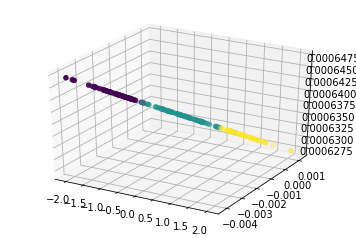

In [122]:
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
winetype = data_set.wine
zdata = mu_result[:,0].numpy()
xdata = mu_result[:,1].numpy()
ydata = mu_result[:,2].numpy()
ax.scatter3D(xdata, ydata, zdata, c=winetype);